In [ ]:
#런타임 끊김 방지
function ClickConnect(){
    console.log("코랩 연결 끊김 방지");
    document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect, 60*1000)

function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);

# wide and deep learning model training

In [ ]:
!pip install scikit-surprise

In [ ]:
!pip install wandb

In [ ]:
!wandb login

wandb: Currently logged in as: mim (use `wandb login --relogin` to force relogin)


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, LabelEncoder
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, SpatialDropout1D, Activation, concatenate
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import ReLU, PReLU, LeakyReLU, ELU
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from tensorflow.keras.utils import plot_model
from surprise.model_selection import cross_validate
import wandb
from wandb.keras import WandbCallback

COLUMN 정의

In [ ]:
COLUMNS = ["user_id" ,"trip", "course", "place_id","place_name", "place_category","rating", "review", "place_address", "place_lat", "place_Ing","y"]
CATEGORICAL_COLUMNS = ["trip", "place_name", "place_category"]
CONTINUOUS_COLUMNS = ["rating", "review", "course","place_lat", "place_Ing"]

DATA LOAD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_0 = pd.read_csv('/content/drive/MyDrive/addr(O)data/couple.csv', names = COLUMNS, header=None, skiprows = 1,thousands = ',')
data_1 = pd.read_csv('/content/drive/MyDrive/addr(O)data/family.csv', names = COLUMNS, header=None, skiprows = 1,thousands = ',')
data_2 = pd.read_csv('/content/drive/MyDrive/addr(O)data/guesthouse1.csv', names = COLUMNS, header=None, skiprows = 1,thousands = ',')
data_3 = pd.read_csv('/content/drive/MyDrive/addr(O)data/guesthouse2.csv', names = COLUMNS, header=None, skiprows = 1,thousands = ',')
data_4 = pd.read_csv('/content/drive/MyDrive/addr(O)data/hotel.csv', names = COLUMNS, header=None, skiprows = 1,thousands = ',')
data_5 = pd.read_csv('/content/drive/MyDrive/addr(O)data/pension1.csv', names = COLUMNS, header=None, skiprows = 1,thousands = ',')
data_6 = pd.read_csv('/content/drive/MyDrive/addr(O)data/pension2.csv', names = COLUMNS, header=None, skiprows = 1,thousands = ',')
data_7 = pd.read_csv('/content/drive/MyDrive/addr(O)data/pension3.csv', names = COLUMNS, header=None, skiprows = 1,thousands = ',')
data_8 = pd.read_csv('/content/drive/MyDrive/addr(O)data/pension4.csv', names = COLUMNS, header=None, skiprows = 1,thousands = ',')

In [ ]:
train_data = pd.concat([data_0, data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8])

In [ ]:
train_sample_data = train_data
train_sample_data.reset_index(drop=True, inplace=True)
train_sample_data

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y
0,0,couple,1,514,버드나무브루어리,"호프,요리주점",4.0,304,강원 강릉시 경강로 1961,37.748230,128.884360,1
1,0,couple,2,501,테라로사 커피공장,커피전문점,3.5,871,강원 강릉시 구정면 현천길 7,37.696005,128.891887,1
2,0,couple,3,4,강문해변,"해수욕장,해변",4.1,197,강원 강릉시 강문동 182-1,37.795486,128.917920,1
3,0,couple,4,676,횡성한우촌,"육류,고기",4.7,37,강원 강릉시 성덕포남로200번길 6,37.769576,128.907955,1
4,0,couple,5,20,경포호,호수,4.3,88,강원 강릉시 초당동,37.791905,128.915830,1
...,...,...,...,...,...,...,...,...,...,...,...,...
91072,11190,pension,8,562,바로방,"제과,베이커리",3.2,153,강원 강릉시 경강로 2092,37.754340,128.895874,0
91073,11935,pension,9,940,뚱할머니순두부,두부전문점,4.3,17,강원 강릉시 난설헌로 211,37.791904,128.912459,0
91074,11494,pension,3,756,스시코우,"초밥,롤",3.3,51,강원 강릉시 하슬라로206번길 16-3,37.767244,128.877471,0
91075,12105,pension,9,2835,홍익돈까스 춘천점,"돈까스,우동",2.6,43,강원 춘천시 새롬공원길5번길 11,37.853221,127.745688,0


In [ ]:
train_sample_data['belief'] = 0
train_sample_data

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y,belief
0,0,couple,1,514,버드나무브루어리,"호프,요리주점",4.0,304,강원 강릉시 경강로 1961,37.748230,128.884360,1,0
1,0,couple,2,501,테라로사 커피공장,커피전문점,3.5,871,강원 강릉시 구정면 현천길 7,37.696005,128.891887,1,0
2,0,couple,3,4,강문해변,"해수욕장,해변",4.1,197,강원 강릉시 강문동 182-1,37.795486,128.917920,1,0
3,0,couple,4,676,횡성한우촌,"육류,고기",4.7,37,강원 강릉시 성덕포남로200번길 6,37.769576,128.907955,1,0
4,0,couple,5,20,경포호,호수,4.3,88,강원 강릉시 초당동,37.791905,128.915830,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91072,11190,pension,8,562,바로방,"제과,베이커리",3.2,153,강원 강릉시 경강로 2092,37.754340,128.895874,0,0
91073,11935,pension,9,940,뚱할머니순두부,두부전문점,4.3,17,강원 강릉시 난설헌로 211,37.791904,128.912459,0,0
91074,11494,pension,3,756,스시코우,"초밥,롤",3.3,51,강원 강릉시 하슬라로206번길 16-3,37.767244,128.877471,0,0
91075,12105,pension,9,2835,홍익돈까스 춘천점,"돈까스,우동",2.6,43,강원 춘천시 새롬공원길5번길 11,37.853221,127.745688,0,0


In [ ]:
n = len(train_sample_data.index)
n_random = int(n*0.2)
n, n_random

(91077, 18215)

In [ ]:
list_row = [] # 랜덤으로 뽑은 값 저장
rnum =random.randrange(0, n-1)
# 0부터 train_smaple_data의 수까지의 범위에서 랜덤한 숫자 한개 추출
 
for i in range(n_random):
  while rnum in list_row:# 뽑은 숫자들이 중복되지 않도록 이미 있는 숫자인지 검사
    rnum = random.randint(0, n-1) # 중복이면 다시 뽑기 
  list_row.append(rnum) # list에 추가

list_size = len(list_row)

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/empty.csv', names = COLUMNS, header=None, skiprows = 1)
test_data

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y


In [ ]:
test_data = train_sample_data.iloc[list_row, :]
test_data

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y,belief
55827,6684,pension,3,217,용연동 마을관리휴양지,유원지,0.0,0,강원 강릉시 사천면 중앙서로 657,37.805710,128.819366,0,0
57875,6208,pension,8,2682,방콕66,태국음식,4.4,60,강원 춘천시 춘천로 340 1층,37.883737,127.749279,0,0
77346,10878,pension,1,8,경포대,문화유적,4.1,95,강원 강릉시 경포로 365,37.795075,128.896598,1,0
6826,2603,guesthouse,1,20,경포호,호수,4.3,88,강원 강릉시 초당동,37.791905,128.915830,1,0
35875,5075,pension,1,650,갈매기다방,카페,3.5,103,강원 강릉시 연곡면 영진길 63 테라스제이 1층,37.870324,128.842946,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84504,11377,pension,3,2599,시골길낙지볶음,"해물,생선",3.5,42,강원 춘천시 영서로2269번길 5,37.863926,127.722272,0,0
60349,8466,pension,1,8,경포대,문화유적,4.1,95,강원 강릉시 경포로 365,37.795075,128.896598,1,0
14163,2727,guesthouse,1,2680,수아마노,이탈리안,4.3,64,강원 춘천시 중앙로77번길 39-2 다동 1층 301호,37.877770,127.729329,0,0
55166,6934,pension,8,2967,고봉삼계탕 춘천점,삼계탕,3.1,22,강원 춘천시 춘천로 12 2층,37.865928,127.721709,0,0


In [ ]:
list_row.sort(reverse=True)

In [ ]:
for i in range(list_size):
  train_sample_data = train_sample_data.drop(list_row[i])
  print(i, end=' ')

train_sample_data

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y,belief
0,0,couple,1,514,버드나무브루어리,"호프,요리주점",4.0,304,강원 강릉시 경강로 1961,37.748230,128.884360,1,0
1,0,couple,2,501,테라로사 커피공장,커피전문점,3.5,871,강원 강릉시 구정면 현천길 7,37.696005,128.891887,1,0
2,0,couple,3,4,강문해변,"해수욕장,해변",4.1,197,강원 강릉시 강문동 182-1,37.795486,128.917920,1,0
3,0,couple,4,676,횡성한우촌,"육류,고기",4.7,37,강원 강릉시 성덕포남로200번길 6,37.769576,128.907955,1,0
4,0,couple,5,20,경포호,호수,4.3,88,강원 강릉시 초당동,37.791905,128.915830,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91072,11190,pension,8,562,바로방,"제과,베이커리",3.2,153,강원 강릉시 경강로 2092,37.754340,128.895874,0,0
91073,11935,pension,9,940,뚱할머니순두부,두부전문점,4.3,17,강원 강릉시 난설헌로 211,37.791904,128.912459,0,0
91074,11494,pension,3,756,스시코우,"초밥,롤",3.3,51,강원 강릉시 하슬라로206번길 16-3,37.767244,128.877471,0,0
91075,12105,pension,9,2835,홍익돈까스 춘천점,"돈까스,우동",2.6,43,강원 춘천시 새롬공원길5번길 11,37.853221,127.745688,0,0


In [ ]:
train_sample_data=train_sample_data.sample(frac=1)
train_sample_data

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y,belief
70355,8054,pension,5,599,강릉커피빵 본점,디저트카페,3.7,161,강원 강릉시 창해로350번길 29,37.796460,128.916850,0,0
26382,793,hotel,1,318,교동,계곡,0.0,0,강원 강릉시 옥계면 현내리,37.608975,129.029199,1,0
71745,8387,pension,8,2926,카페슬로울리,카페,5.0,23,강원 춘천시 춘천로407번길 10 1층,37.890323,127.751087,0,0
40312,6063,pension,7,989,미미네횟집,회,4.8,4,강원 강릉시 주문진읍 해안로 1917,37.901433,128.830977,0,0
45028,6133,pension,7,2951,황금송어회,회,3.4,4,강원 춘천시 승지골길13번길 3-4,37.849813,127.739795,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27823,1713,hotel,2,8,경포대,문화유적,4.1,95,강원 강릉시 경포로 365,37.795075,128.896598,1,0
27937,1787,hotel,1,4,강문해변,"해수욕장,해변",4.1,197,강원 강릉시 강문동 182-1,37.795486,128.917920,1,0
54798,7306,pension,6,999,육즙가득한고기집 육고집 강릉직영점,"육류,고기",5.0,14,강원 강릉시 사임당로 133,37.766299,128.861114,0,0
31024,1728,hotel,9,2472,여의내골,계곡,0.0,0,강원 춘천시 남면 가정리,37.756295,127.583001,0,0


In [ ]:
tmp_1 = train_sample_data
tme_2 = test_data

In [ ]:
#train_sample_data = train_data.sample(frac=0.8, random_state=1) 랜덤으로 데이터 뽑기

In [ ]:
train_sample_data.isna().sum()

user_id           0
trip              0
course            0
place_id          0
place_name        0
place_category    0
rating            0
review            0
place_address     0
place_lat         0
place_Ing         0
y                 0
belief            0
dtype: int64

In [ ]:
test_data.isna().sum()

user_id           0
trip              0
course            0
place_id          0
place_name        0
place_category    0
rating            0
review            0
place_address     0
place_lat         0
place_Ing         0
y                 0
belief            0
dtype: int64

DATA CONCAT

In [ ]:
data = pd.concat([train_sample_data, test_data])

In [ ]:
print(data.shape)
data.head()

(91077, 13)


,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y,belief
70355,8054,pension,5,599,강릉커피빵 본점,디저트카페,3.7,161,강원 강릉시 창해로350번길 29,37.796460,128.916850,0,0
26382,793,hotel,1,318,교동,계곡,0.0,0,강원 강릉시 옥계면 현내리,37.608975,129.029199,1,0
71745,8387,pension,8,2926,카페슬로울리,카페,5.0,23,강원 춘천시 춘천로407번길 10 1층,37.890323,127.751087,0,0
40312,6063,pension,7,989,미미네횟집,회,4.8,4,강원 강릉시 주문진읍 해안로 1917,37.901433,128.830977,0,0
45028,6133,pension,7,2951,황금송어회,회,3.4,4,강원 춘천시 승지골길13번길 3-4,37.849813,127.739795,0,0


label 값 생성

In [ ]:
y = data['y'].values
#data.drop('y', axis=1, inplace=True)
data.drop('place_address', axis=1, inplace=True)

In [ ]:
data.head()

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_lat,place_Ing,y,belief
70355,8054,pension,5,599,강릉커피빵 본점,디저트카페,3.7,161,37.796460,128.916850,0,0
26382,793,hotel,1,318,교동,계곡,0.0,0,37.608975,129.029199,1,0
71745,8387,pension,8,2926,카페슬로울리,카페,5.0,23,37.890323,127.751087,0,0
40312,6063,pension,7,989,미미네횟집,회,4.8,4,37.901433,128.830977,0,0
45028,6133,pension,7,2951,황금송어회,회,3.4,4,37.849813,127.739795,0,0


CATEGORICAL 값들 숫자로 변경

In [ ]:
le = LabelEncoder()
for c in CATEGORICAL_COLUMNS:
  if c in data.columns:
    i = data.columns.get_loc(c)
    data.iloc[:,i] = data.apply(lambda i:le.fit_transform(i.astype(str)), axis=0, result_type='expand')

In [ ]:
data

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_lat,place_Ing,y,belief
70355,8054,4,5,599,105,34,3.7,161,37.796460,128.916850,0,0
26382,793,3,1,318,232,7,0.0,0,37.608975,129.029199,1,0
71745,8387,4,8,2926,1633,110,5.0,23,37.890323,127.751087,0,0
40312,6063,4,7,989,622,138,4.8,4,37.901433,128.830977,0,0
45028,6133,4,7,2951,1875,138,3.4,4,37.849813,127.739795,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
84504,11377,4,3,2599,992,130,3.5,42,37.863926,127.722272,0,0
60349,8466,4,1,8,174,42,4.1,95,37.795075,128.896598,1,0
14163,2727,2,1,2680,947,84,4.3,64,37.877770,127.729329,0,0
55166,6934,4,8,2967,203,57,3.1,22,37.865928,127.721709,0,0


train, test data 분리

In [ ]:
train_size = len(train_sample_data)

In [ ]:
X_train = data.iloc[:train_size]
y_train = y[:train_size]
X_test = data.iloc[train_size:]
y_test = y[train_size:]

In [ ]:
print(len(X_train),len(y_train), len(X_test), len(y_test))

72862 72862 18215 18215


catecorical, continuous 값 뽑기

In [ ]:
X_train_category = np.array(X_train[CATEGORICAL_COLUMNS])
X_test_category = np.array(X_test[CATEGORICAL_COLUMNS])
X_train_countinue = np.array(X_train[CONTINUOUS_COLUMNS], dtype='float64')
X_test_countinue = np.array(X_test[CONTINUOUS_COLUMNS], dtype='float64')

In [ ]:
print(X_train_category[:1])
print(X_test_category[:1])
print(X_train_countinue[:1])
print(X_test_countinue[:1])

[[  4 105  34]]
[[   4 1220   81]]
[[  3.7       161.          5.         37.7964603 128.9168498]]
[[  0.          0.          3.         37.8057096 128.8193664]]


CONTINUOUS DATA 정규화

In [ ]:
scaler = StandardScaler()
X_train_countinue = scaler.fit_transform(X_train_countinue)
X_test_countinue = scaler.transform(X_test_countinue)

In [ ]:
print(X_train_countinue[:1])
print(X_test_countinue[:1])

[[ 0.50767708  0.53988395  0.10923322 -0.22728718  0.87155967]]
[[-1.40933301 -0.44361206 -0.54777116 -0.11425809  0.70226514]]


categorical -> polynomial

In [ ]:
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_category_poly = poly.fit_transform(X_train_category)
X_test_category_poly = poly.transform(X_test_category)

In [ ]:
print(X_train_category_poly[:1])
print(X_test_category_poly[:1])

[[1.00e+00 4.00e+00 1.05e+02 3.40e+01 4.20e+02 1.36e+02 3.57e+03]]
[[1.000e+00 4.000e+00 1.220e+03 8.100e+01 4.880e+03 3.240e+02 9.882e+04]]


In [ ]:
n = np.array([[1, 2, 3]])
poly2 = PolynomialFeatures(degree=2, interaction_only=True)
print(poly.fit_transform(n))

[[1. 1. 2. 3. 2. 3. 6.]]


deep model

In [ ]:
def f_deep_model():

    category_inputs = []
    category_embeds = []

    # categorical data embedding
    for i in range(len(CATEGORICAL_COLUMNS)):
        input_i = Input(shape=(1,), dtype='int32')
        dim = len(np.unique(data[CATEGORICAL_COLUMNS[i]]))
        embed_dim = int(np.ceil(dim * 0.5))  # embedding dim 1/2
        embed_i = Embedding(dim, embed_dim, input_length=1)(input_i)
        flatten_i = Flatten()(embed_i)
        category_inputs.append(input_i)
        category_embeds.append(flatten_i)

    # continuous data input
    continue_input = Input(shape=(len(CONTINUOUS_COLUMNS),))
    continue_dense = Dense(256, use_bias=False)(continue_input)

    # category + continue를
    concat_embeds = concatenate([continue_dense] + category_embeds)
    concat_embeds = Activation('relu')(concat_embeds)
    bn_concat = BatchNormalization()(concat_embeds)

    fc1 = Dense(512, use_bias=False)(bn_concat)
    relu1 = ReLU()(fc1)
    bn1 = BatchNormalization()(relu1)
    fc2 = Dense(256, use_bias=False)(bn1)
    relu2 = ReLU()(fc2)
    bn2 = BatchNormalization()(relu2)
    fc3 = Dense(128)(bn2)
    relu3 = ReLU()(fc3)

    return category_inputs, continue_input, relu3

wide model

In [ ]:
def f_wide_model():
    dim = X_train_category_poly.shape[1]
    return Input(shape=(dim,))

In [ ]:
category_inputs, continue_input, deep_model = f_deep_model()
wide_model = f_wide_model()

wide + deep

In [ ]:
out_layer = concatenate([deep_model, wide_model])
inputs = [continue_input] + category_inputs + [wide_model]
output = Dense(1, activation='sigmoid')(out_layer)
model = Model(inputs=inputs, outputs=output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 5)]          0                                            
______________________________________________________________________________________________

In [ ]:
checkpoint = ModelCheckpoint(filepath='./data/wide-deep.h5', monitor='val_loss', verbose=1, save_best_only=True)
#early_stopping = EarlyStopping(monitor='val_loss', patience=5)

data -> model training

In [ ]:
input_data = [X_train_countinue] + [X_train_category[:, i]
                                    for i in range(X_train_category.shape[1])] + [X_train_category_poly]

In [ ]:
epochs = 50
optimizer = 'adam'
batch_size = 128

In [ ]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

run = wandb.init(project='FINAL_wide and deep learning',
                 config={  # and include hyperparameters and metadata
                     "epochs": 50,
                     "batch_size":128,
                     "loss_function": "binary_crossentropy",
                     "architecture": "wide and deep learning",
                     "dataset": "all",
                     "주소 dataset" : "continuous",
                     "belief" : "true",
                 })
config = wandb.config  # We'll use this to configure our experiment
callbacks=[checkpoint, WandbCallback()] #콜백함수에 chkpt추가 (early_stop)
tf.keras.backend.clear_session()

epoch,11
loss,0.42633
accuracy,0.97321
val_loss,4.4431
val_accuracy,0.8646
_runtime,13
_timestamp,1623770833
_step,11
best_val_loss,4.4431
best_epoch,11


epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▄▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▁▇█▇██████
val_loss,█▄▁▁▁▁▁▁▁▁▁▁
val_accuracy,▃▂▂▃▂▁▁▂▃▅██
_runtime,▁▁▂▂▃▃▅▆▆▇▇█
_timestamp,▁▁▂▂▃▃▅▆▆▇▇█
_step,▁▂▂▃▄▄▅▅▆▇▇█


In [ ]:
hist = model.fit(input_data, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.15, callbacks=callbacks)

run.join()

print(hist.history.keys())

Epoch 1/50
484/484 [==============================] - 9s 14ms/step - loss: 167.8794 - accuracy: 0.8832 - val_loss: 4.2149 - val_accuracy: 0.9231

Epoch 00001: val_loss improved from inf to 4.21487, saving model to ./data/wide-deep.h5
Epoch 2/50
484/484 [==============================] - 6s 13ms/step - loss: 1.7561 - accuracy: 0.9571 - val_loss: 1.5226 - val_accuracy: 0.9550

Epoch 00002: val_loss improved from 4.21487 to 1.52259, saving model to ./data/wide-deep.h5
Epoch 3/50
484/484 [==============================] - 6s 13ms/step - loss: 1.0390 - accuracy: 0.9569 - val_loss: 1.4619 - val_accuracy: 0.9618

Epoch 00003: val_loss improved from 1.52259 to 1.46191, saving model to ./data/wide-deep.h5
Epoch 4/50
484/484 [==============================] - 6s 13ms/step - loss: 1.0954 - accuracy: 0.9561 - val_loss: 0.4722 - val_accuracy: 0.9667

Epoch 00004: val_loss improved from 1.46191 to 0.47219, saving model to ./data/wide-deep.h5
Epoch 5/50
484/484 [==============================] - 6s 1

epoch,49
loss,0.63859
accuracy,0.96767
val_loss,0.93786
val_accuracy,0.9721
_runtime,320
_timestamp,1623771313
_step,49
best_val_loss,0.33221
best_epoch,6


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▆▆▆▆▆▆▆▆▇▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇█▇▇▇█▇████████
val_loss,█▃▃▁▁▁▃▂▂▁▂▁▁▄▂▄▄▂▃▃▄▂▂▃▂▃▂▂▆▂▂▂▂▂▄▂▂▃▃▂
val_accuracy,▂▆▇▇█▇▂▇▅█▇▆▇▄█▅▆█▅▅▁▇█▆▇▇▆▇▅████▆▆▇██▆█
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


evaluation

In [ ]:
eval_input_data = [X_test_countinue] + [X_test_category[:, i]
                                        for i in range(X_test_category.shape[1])] + [X_test_category_poly]

In [ ]:
loss, acc = model.evaluate(eval_input_data, y_test)

570/570 [==============================] - 1s 2ms/step - loss: 1.0846 - accuracy: 0.9695


In [ ]:
print(f'test_loss: {loss} - test_acc: {acc}')

test_loss: 1.084615707397461 - test_acc: 0.9694756865501404


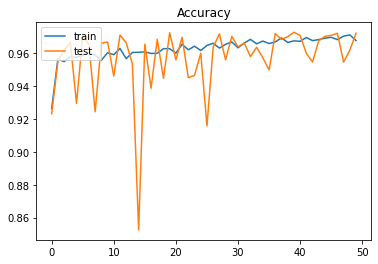

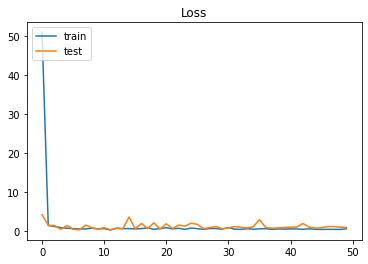

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

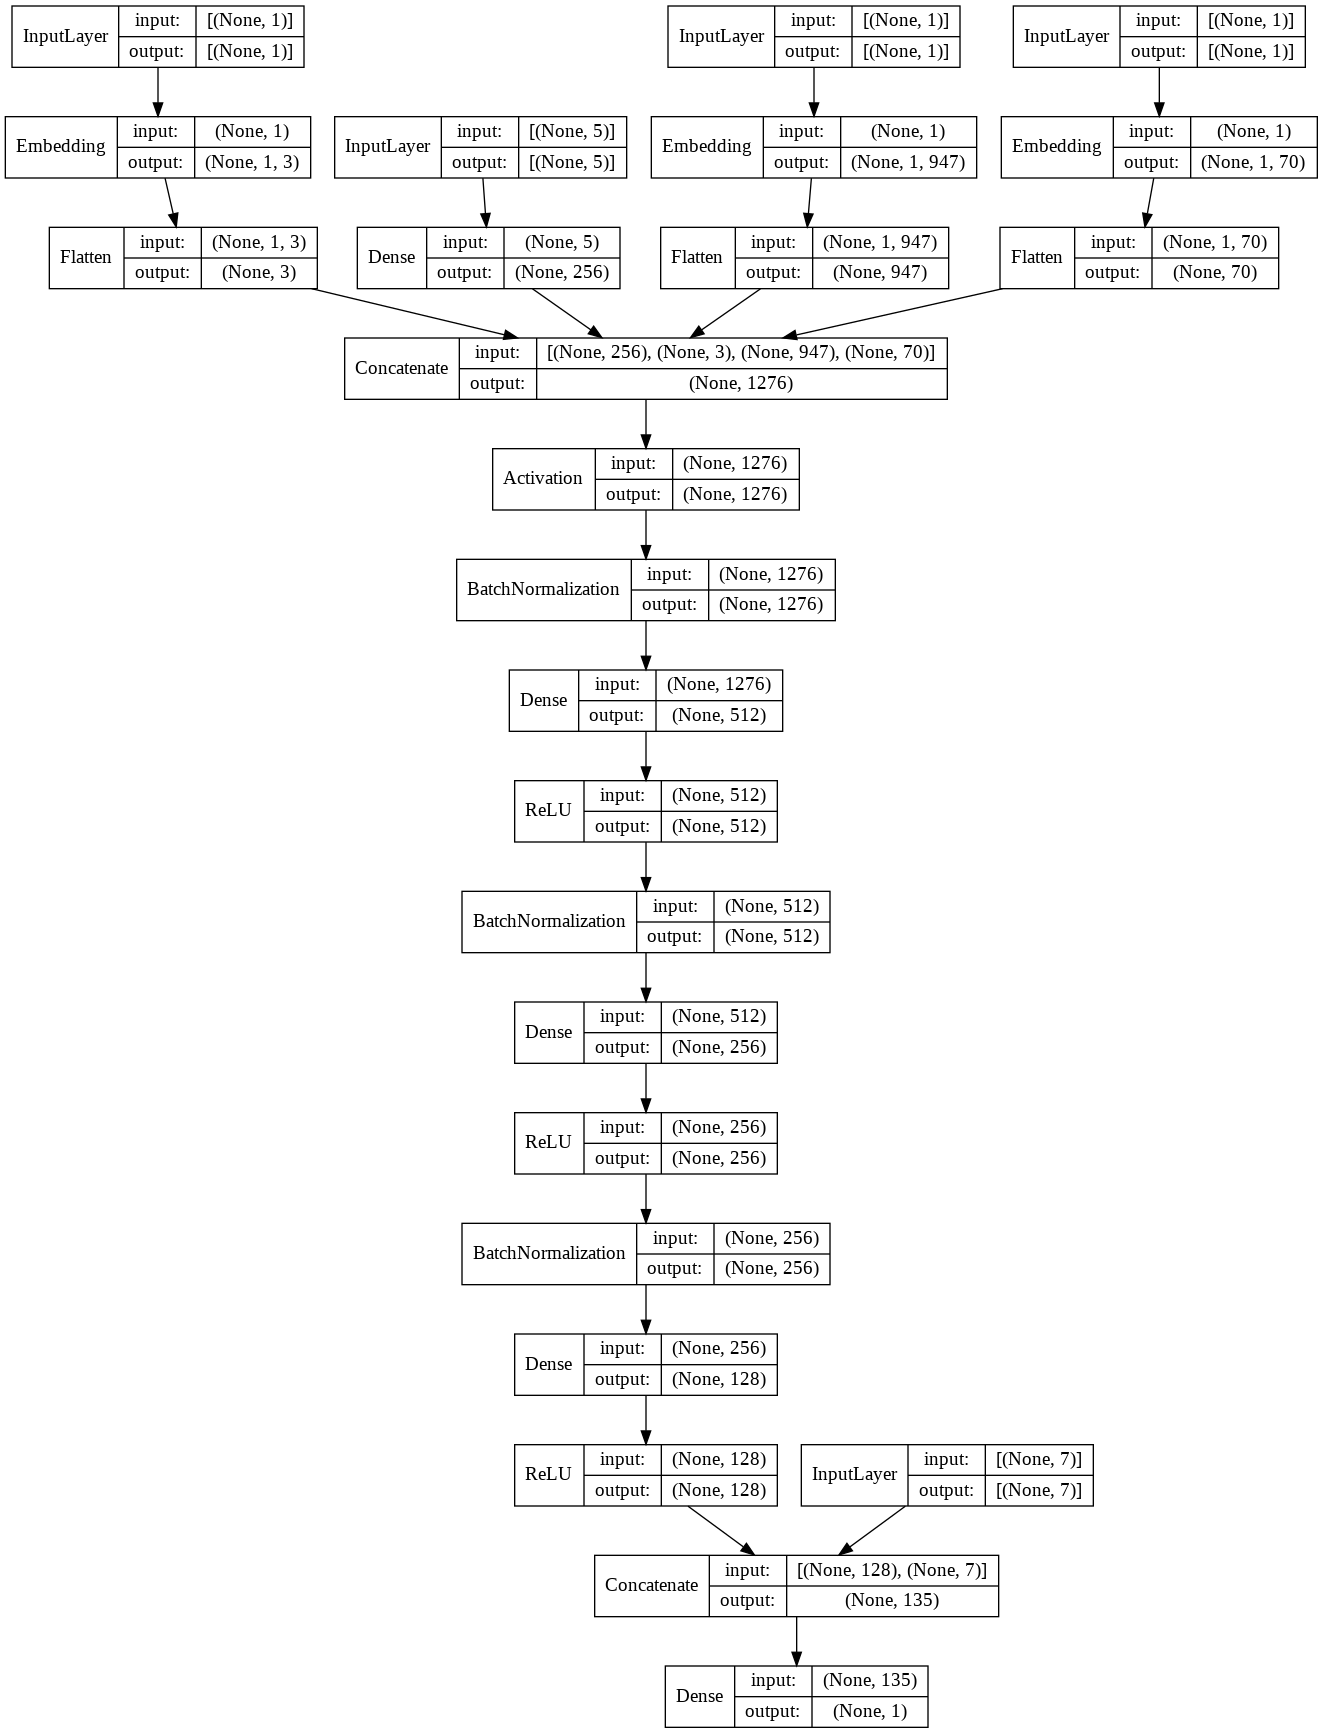

In [ ]:
plot_model(model, to_file='./data/model.png',
           show_shapes=True, show_layer_names=False)

# 추천 리스트 데이터

In [ ]:
full_data_0 = pd.read_csv('/content/drive/MyDrive/addr(O)data/couple_full.csv', names = COLUMNS, header=None, skiprows = 1,thousands = ',')
full_data_1 = pd.read_csv('/content/drive/MyDrive/addr(O)data/family_full.csv', names = COLUMNS, header=None, skiprows = 1,thousands = ',')
full_data_2 = pd.read_csv('/content/drive/MyDrive/addr(O)data/guesthouse1_full.csv', names = COLUMNS, header=None, skiprows = 1,thousands = ',')
full_data_3 = pd.read_csv('/content/drive/MyDrive/addr(O)data/guesthouse2_full.csv', names = COLUMNS, header=None, skiprows = 1,thousands = ',')
full_data_4 = pd.read_csv('/content/drive/MyDrive/addr(O)data/hotel_full.csv', names = COLUMNS, header=None, skiprows = 1,thousands = ',')
full_data_5 = pd.read_csv('/content/drive/MyDrive/addr(O)data/pension1_full.csv', names = COLUMNS, header=None, skiprows = 1,thousands = ',')
full_data_6 = pd.read_csv('/content/drive/MyDrive/addr(O)data/pension2_full.csv', names = COLUMNS, header=None, skiprows = 1,thousands = ',')
full_data_7 = pd.read_csv('/content/drive/MyDrive/addr(O)data/pension3_full.csv', names = COLUMNS, header=None, skiprows = 1,thousands = ',')
full_data_8 = pd.read_csv('/content/drive/MyDrive/addr(O)data/pension4_full.csv', names = COLUMNS, header=None, skiprows = 1,thousands = ',')

In [ ]:
data_couple = full_data_0.copy()
data_family = full_data_1.copy()
data_hotel = full_data_4.copy()
data_guesthouse = pd.concat([full_data_2,full_data_3])
data_pension = pd.concat([full_data_5,full_data_6,full_data_7,full_data_8])

data_couple.reset_index(drop=True, inplace=True)
data_family.reset_index(drop=True, inplace=True)
data_hotel.reset_index(drop=True, inplace=True)
data_guesthouse.reset_index(drop=True, inplace=True)
data_pension.reset_index(drop=True, inplace=True)

In [ ]:
data_couple['belief'] = 0
data_family['belief'] = 0
data_hotel['belief'] = 0         
data_guesthouse['belief'] = 0
data_pension['belief'] = 0

In [ ]:
data_couple = data_couple.drop_duplicates(['user_id','place_id'])
data_family = data_family.drop_duplicates(['user_id','place_id'])
data_hotel = data_hotel.drop_duplicates(['user_id','place_id'])
data_guesthouse = data_guesthouse.drop_duplicates(['user_id','place_id'])
data_pension = data_pension.drop_duplicates(['user_id','place_id'])

In [ ]:
data_couple.shape

(1290322, 13)

In [ ]:
data_couple

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y,belief
0,0,couple,1,514,버드나무브루어리,"호프,요리주점",4.0,304,강원 강릉시 경강로 1961,37.748230,128.884360,1,0
1,0,couple,2,501,테라로사 커피공장,커피전문점,3.5,871,강원 강릉시 구정면 현천길 7,37.696005,128.891887,1,0
2,0,couple,3,4,강문해변,"해수욕장,해변",4.1,197,강원 강릉시 강문동 182-1,37.795486,128.917920,1,0
3,0,couple,4,676,횡성한우촌,"육류,고기",4.7,37,강원 강릉시 성덕포남로200번길 6,37.769576,128.907955,1,0
4,0,couple,5,20,경포호,호수,4.3,88,강원 강릉시 초당동,37.791905,128.915830,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291552,658,couple,8,2996,황소돌곱창구이,"곱창,막창",5.0,17,강원 춘천시 우석로67번길 17,37.865485,127.750965,0,0
1291553,658,couple,5,2997,스시마루,"초밥,롤",3.0,11,강원 춘천시 스무숲길 1,37.850043,127.748694,0,0
1291554,658,couple,10,2998,부용산장가든,한식,3.6,14,강원 춘천시 북산면 오봉산길 672,37.979383,127.816946,0,0
1291555,658,couple,7,2999,청춘활어,회,4.3,20,강원 춘천시 애막골길7번길 29 1층,37.867057,127.752314,0,0


In [ ]:
data_family

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y,belief
0,659,family,1,508,벌집,국수,3.2,377,강원 강릉시 경강로2069번길 15,37.754505,128.892756,1,0
1,660,family,1,318,교동,계곡,0.0,0,강원 강릉시 옥계면 현내리,37.608975,129.029199,1,0
2,661,family,1,2,경포해변,"해수욕장,해변",4.1,194,강원 강릉시 창해로 514,37.805779,128.907417,1,0
3,661,family,2,20,경포호,호수,4.3,88,강원 강릉시 초당동,37.791905,128.915830,1,0
4,662,family,1,8,경포대,문화유적,4.1,95,강원 강릉시 경포로 365,37.795075,128.896598,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219456,770,family,6,2996,황소돌곱창구이,"곱창,막창",5.0,17,강원 춘천시 우석로67번길 17,37.865485,127.750965,0,0
219457,770,family,6,2997,스시마루,"초밥,롤",3.0,11,강원 춘천시 스무숲길 1,37.850043,127.748694,0,0
219458,770,family,10,2998,부용산장가든,한식,3.6,14,강원 춘천시 북산면 오봉산길 672,37.979383,127.816946,0,0
219459,770,family,9,2999,청춘활어,회,4.3,20,강원 춘천시 애막골길7번길 29 1층,37.867057,127.752314,0,0


In [ ]:
data_hotel

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y,belief
0,771,hotel,1,8,경포대,문화유적,4.1,95,강원 강릉시 경포로 365,37.795075,128.896598,1,0
1,772,hotel,1,318,교동,계곡,0.0,0,강원 강릉시 옥계면 현내리,37.608975,129.029199,1,0
2,773,hotel,1,318,교동,계곡,0.0,0,강원 강릉시 옥계면 현내리,37.608975,129.029199,1,0
3,774,hotel,1,318,교동,계곡,0.0,0,강원 강릉시 옥계면 현내리,37.608975,129.029199,1,0
4,775,hotel,1,601,정감,퓨전요리,3.8,151,강원 강릉시 가작로 34,37.771343,128.900328,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2400431,1995,hotel,3,2996,황소돌곱창구이,"곱창,막창",5.0,17,강원 춘천시 우석로67번길 17,37.865485,127.750965,0,0
2400432,1995,hotel,1,2997,스시마루,"초밥,롤",3.0,11,강원 춘천시 스무숲길 1,37.850043,127.748694,0,0
2400433,1995,hotel,8,2998,부용산장가든,한식,3.6,14,강원 춘천시 북산면 오봉산길 672,37.979383,127.816946,0,0
2400434,1995,hotel,9,2999,청춘활어,회,4.3,20,강원 춘천시 애막골길7번길 29 1층,37.867057,127.752314,0,0


In [ ]:
data_guesthouse

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y,belief
0,1996,guesthouse,1,550,항구마차,"해물,생선",4.2,86,강원 강릉시 옥계면 금진리 149-3,37.648442,129.046904,1,0
1,1996,guesthouse,2,173,헌화로,드라이브코스,3.5,12,강원 강릉시 강동면 심곡리,37.667299,129.041663,1,0
2,1997,guesthouse,1,8,경포대,문화유적,4.1,95,강원 강릉시 경포로 365,37.795075,128.896598,1,0
3,1997,guesthouse,2,7,오죽헌,유적지,4.1,451,강원 강릉시 율곡로3139번길 24,37.779184,128.879458,1,0
4,1998,guesthouse,1,29,금진해변,"해수욕장,해변",4.1,10,강원 강릉시 옥계면 금진리,37.643212,129.036707,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5410237,4756,guesthouse,1,2996,황소돌곱창구이,"곱창,막창",5.0,17,강원 춘천시 우석로67번길 17,37.865485,127.750965,0,0
5410238,4756,guesthouse,6,2997,스시마루,"초밥,롤",3.0,11,강원 춘천시 스무숲길 1,37.850043,127.748694,0,0
5410239,4756,guesthouse,3,2998,부용산장가든,한식,3.6,14,강원 춘천시 북산면 오봉산길 672,37.979383,127.816946,0,0
5410240,4756,guesthouse,1,2999,청춘활어,회,4.3,20,강원 춘천시 애막골길7번길 29 1층,37.867057,127.752314,0,0


In [ ]:
data_pension

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y,belief
0,4757,pension,1,8,경포대,문화유적,4.1,95,강원 강릉시 경포로 365,37.795075,128.896598,1,0
1,4758,pension,1,8,경포대,문화유적,4.1,95,강원 강릉시 경포로 365,37.795075,128.896598,1,0
2,4759,pension,1,2,경포해변,"해수욕장,해변",4.1,194,강원 강릉시 창해로 514,37.805779,128.907417,1,0
3,4760,pension,1,8,경포대,문화유적,4.1,95,강원 강릉시 경포로 365,37.795075,128.896598,1,0
4,4761,pension,1,8,경포대,문화유적,4.1,95,강원 강릉시 경포로 365,37.795075,128.896598,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14559935,12186,pension,7,2996,황소돌곱창구이,"곱창,막창",5.0,17,강원 춘천시 우석로67번길 17,37.865485,127.750965,0,0
14559936,12186,pension,2,2997,스시마루,"초밥,롤",3.0,11,강원 춘천시 스무숲길 1,37.850043,127.748694,0,0
14559937,12186,pension,6,2998,부용산장가든,한식,3.6,14,강원 춘천시 북산면 오봉산길 672,37.979383,127.816946,0,0
14559938,12186,pension,8,2999,청춘활어,회,4.3,20,강원 춘천시 애막골길7번길 29 1층,37.867057,127.752314,0,0


# 추천 리스트 함수

데이터 로드 후 belief 항목 추가

In [ ]:
# data_df_1 = pd.concat([data_0, data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8])
# data_df_1.reset_index(drop=True, inplace=True)
# data_df_1['belief'] = 0

데이터 가공 함수

In [ ]:
def data_process(f_data): 
  y = f_data['y'].values
  #f_data.drop('y', axis=1, inplace=True)
  f_data.drop('place_address', axis=1, inplace=True)

  f_le = LabelEncoder()
  for c in CATEGORICAL_COLUMNS:
    if c in f_data.columns:
      i = f_data.columns.get_loc(c)
      f_data.iloc[:,i] = f_data.apply(lambda i:f_le.fit_transform(i.astype(str)), axis=0, result_type='expand')

  f_train_size = len(f_data)

  f_X_train = f_data.iloc[:f_train_size]
  f_y_train = y[:f_train_size]

  f_X_train_category = np.array(f_X_train[CATEGORICAL_COLUMNS])
  f_X_train_countinue = np.array(f_X_train[CONTINUOUS_COLUMNS], dtype='float64')

  f_scaler = StandardScaler()
  f_X_train_countinue = f_scaler.fit_transform(f_X_train_countinue)

  f_poly = PolynomialFeatures(degree=2, interaction_only=True)
  f_X_train_category_poly = f_poly.fit_transform(f_X_train_category)

  f_n = np.array([[1, 2, 3]])
  f_poly2 = PolynomialFeatures(degree=2, interaction_only=True)

  return [f_X_train_countinue] + [f_X_train_category[:, i]
                                    for i in range(f_X_train_category.shape[1])] + [f_X_train_category_poly]

추천 리스트 함수
*   데이터 가공
*   모델 예측함수 실행
*   예측된 y값 list로 변환
*   이중 배열 -> 단일 배열로 변환
*   추천 리스트로 사용할 데이터 예측 y colums 추가
*   예측된 y값 정렬



In [ ]:
def recommend_li(model, data_df_1, user_id):
  test1_df = data_df_1[data_df_1['user_id'] == user_id]
  test1_r = data_df_1[data_df_1['user_id'] == user_id]
  test1_input =  data_process(test1_df)
  scores = model.predict(test1_input, batch_size=128)
  scores = scores.tolist()
  yy = []
  for i in range(len(scores)):
    yy.append(scores[i][0])
  test1_r['y_pred'] = yy
  test1_r = test1_r.sort_values(by=['y_pred'], axis=0, ascending=False)

  return test1_r[:5]

In [ ]:
def upgrade_belief(test1_r, data_df_1, model):
  re_list = test1_r[:5]['place_id'].values
  belief_df = pd.DataFrame(columns=['user_id',	'trip',	'course', 'place_id',	'place_name',	'place_category',	'rating',	'review',	'place_address', 'place_lat', 'place_Ing', 'y', 'belief'])

  for x in re_list:
    belief_df = belief_df.append(data_df_1[data_df_1['place_id'] == x])
  data_df_1 = data_df_1.drop(belief_df.index)
  belief_df = belief_df.values.tolist()
  test1_r = test1_r[:5].values.tolist()

  for y in range(len(test1_r)): 
    for x in range(len(belief_df)):
      if ((belief_df[x][3] == test1_r[y][3]) and (test1_r[y][11] == 0)):
        belief_df[x][12] = belief_df[x][12] - 5
      elif ((belief_df[x][3] == test1_r[y][3]) and (test1_r[y][11] == 1)):
        belief_df[x][12] = belief_df[x][12] + 5

  up_df = pd.DataFrame(belief_df, columns=['user_id',	'trip',	'course', 'place_id',	'place_name',	'place_category',	'rating',	'review',	'place_address', 'place_lat', 'place_Ing', 'y', 'belief'])
  up_df_y = up_df['y'].values
  data_df_1 = pd.concat([data_df_1,up_df], ignore_index=True)

  test1_input= data_process(up_df)

  hist = model.fit(test1_input,up_df_y , epochs=50, batch_size=128, validation_split=0.15, callbacks=checkpoint)

  return data_df_1

# 카테고리별 추천 리스트 생성


> 커플









In [ ]:
from random import *
data_df_2 = data_couple.copy()
final_re_1 = pd.DataFrame(columns=['user_id',	'trip',	'course', 'place_id',	'place_name',	'place_category',	'rating',	'review',	'place_address', 'place_lat', 'place_Ing', 'y', 'belief','y_pred'])

id_li = [649,257,176,424,267,239,400,361,472,67,159,231,452,232,102,229,1,36,113,199,496,303,588,102,576,255,471,406,193,630,366,159,550,6,610,544,261,230,514,550,408,370,571,136,446,472,331,205,156,596]

#id_li = []
for k in range(0,50):
  #i = randint(0,658)
  #id_li.append(i)
  i = id_li[k]
  test1_c = recommend_li(model, data_couple, i)
  final_re_1 = final_re_1.append(test1_c)
  data_df_2 = upgrade_belief(test1_c, data_df_2, model)
  print("현재 위치 : " , k+1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 0.8082 - accuracy: 0.9664 - val_loss: 0.0381 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from 0.33221 to 0.03810, saving model to ./data/wide-deep.h5
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 0.2060 - accuracy: 0.9814 - val_loss: 0.0183 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.03810 to 0.01828, saving model to ./data/wide-deep.h5
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 0.1890 - accuracy: 0.9857 - val_loss: 0.0218 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.01828
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0981 - accuracy: 0.9829 - val_loss: 0.0137 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.01828 to 0.01367, saving model to ./data/wide-deep.h5
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0657 - accuracy: 0.9871 - val_

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 0.2040 - accuracy: 0.9461 - val_loss: 0.0367 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.01367
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 0.1139 - accuracy: 0.9557 - val_loss: 0.0308 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.01367
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 0.1030 - accuracy: 0.9579 - val_loss: 0.0160 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.01367
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 0.1013 - accuracy: 0.9557 - val_loss: 0.0129 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.01367 to 0.01288, saving model to ./data/wide-deep.h5
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0987 - accuracy: 0.9564 - val_loss: 0.0129 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0757 - accuracy: 0.9854 - val_loss: 1.8440e-09 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from 0.00063 to 0.00000, saving model to ./data/wide-deep.h5
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 9.9494e-04 - accuracy: 1.0000 - val_loss: 2.7080e-10 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.00000 to 0.00000, saving model to ./data/wide-deep.h5
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 3.6797e-04 - accuracy: 1.0000 - val_loss: 1.4032e-10 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.00000 to 0.00000, saving model to ./data/wide-deep.h5
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 2.8886e-04 - accuracy: 1.0000 - val_loss: 9.3269e-11 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.00000 to 0.00000, saving model to ./data/wide-deep.h5
Epoch 5/50
22/22 [==================

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0024 - accuracy: 0.9989 - val_loss: 4.1317e-06 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 6.3964e-05 - accuracy: 1.0000 - val_loss: 1.9252e-06 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 3.4520e-05 - accuracy: 1.0000 - val_loss: 2.1007e-06 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 2.4794e-05 - accuracy: 1.0000 - val_loss: 2.3878e-06 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 2.0466e-05 - accuracy: 1.0000 - val_loss: 2.5768e-06 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 14ms/step - loss: 3.4114e-06 - accuracy: 1.0000 - val_loss: 9.9331e-09 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 3.2004e-06 - accuracy: 1.0000 - val_loss: 4.4057e-08 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 2.6619e-06 - accuracy: 1.0000 - val_loss: 9.3783e-08 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 2.5015e-06 - accuracy: 1.0000 - val_loss: 1.4761e-07 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 2.1969e-06 - accuracy: 1.0000 - val_loss: 1.9818e-07 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 3.6018e-06 - accuracy: 1.0000 - val_loss: 2.4559e-06 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 2.9213e-06 - accuracy: 1.0000 - val_loss: 2.1528e-06 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 2.8091e-06 - accuracy: 1.0000 - val_loss: 2.0311e-06 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 2.0918e-06 - accuracy: 1.0000 - val_loss: 2.0790e-06 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 1.5873e-06 - accuracy: 1.0000 - val_loss: 2.0411e-06 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 1.6919e-07 - accuracy: 1.0000 - val_loss: 3.3681e-16 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from 0.00000 to 0.00000, saving model to ./data/wide-deep.h5
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 1.7763e-07 - accuracy: 1.0000 - val_loss: 3.2908e-16 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.00000 to 0.00000, saving model to ./data/wide-deep.h5
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 1.7782e-07 - accuracy: 1.0000 - val_loss: 1.0558e-16 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.00000 to 0.00000, saving model to ./data/wide-deep.h5
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 1.5106e-07 - accuracy: 1.0000 - val_loss: 3.3771e-17 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.00000 to 0.00000, saving model to ./data/wide-deep.h5
Epoch 5/50
22/22 [==============

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 6.9651e-09 - accuracy: 1.0000 - val_loss: 4.3733e-06 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 1.2765e-08 - accuracy: 1.0000 - val_loss: 1.6108e-06 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 8.2814e-09 - accuracy: 1.0000 - val_loss: 7.7731e-07 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 1.3318e-08 - accuracy: 1.0000 - val_loss: 4.1350e-07 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 1.4522e-08 - accuracy: 1.0000 - val_loss: 2.5736e-07 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 3.2118e-08 - accuracy: 1.0000 - val_loss: 9.3432e-10 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 3.3733e-08 - accuracy: 1.0000 - val_loss: 5.5214e-10 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 3.2268e-08 - accuracy: 1.0000 - val_loss: 3.2401e-10 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 4.0162e-08 - accuracy: 1.0000 - val_loss: 1.9504e-10 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 3.6558e-08 - accuracy: 1.0000 - val_loss: 1.5272e-10 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 14ms/step - loss: 1.5864e-07 - accuracy: 1.0000 - val_loss: 1.4891e-09 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 1.5846e-07 - accuracy: 1.0000 - val_loss: 1.2110e-09 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 1.1702e-07 - accuracy: 1.0000 - val_loss: 9.7739e-10 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 1.1751e-07 - accuracy: 1.0000 - val_loss: 8.1463e-10 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 1.0311e-07 - accuracy: 1.0000 - val_loss: 7.0527e-10 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 2.9341e-07 - accuracy: 1.0000 - val_loss: 4.2004e-08 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 2.9061e-07 - accuracy: 1.0000 - val_loss: 4.0768e-08 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 5.7825e-07 - accuracy: 1.0000 - val_loss: 3.4927e-10 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 2.5807e-07 - accuracy: 1.0000 - val_loss: 3.2447e-11 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 1.5055e-07 - accuracy: 1.0000 - val_loss: 2.4623e-12 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 16ms/step - loss: 2.8073e-08 - accuracy: 1.0000 - val_loss: 1.7315e-04 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 6.2476e-08 - accuracy: 1.0000 - val_loss: 6.3294e-05 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 1.1950e-08 - accuracy: 1.0000 - val_loss: 2.8149e-05 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 2.0789e-08 - accuracy: 1.0000 - val_loss: 1.1361e-05 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 1.5771e-08 - accuracy: 1.0000 - val_loss: 5.6107e-06 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 9.8629e-10 - accuracy: 1.0000 - val_loss: 2.1318e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 1.1762e-09 - accuracy: 1.0000 - val_loss: 2.9030e-16 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 1.1354e-09 - accuracy: 1.0000 - val_loss: 1.8443e-18 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 7.2947e-10 - accuracy: 1.0000 - val_loss: 1.2749e-20 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 1.6850e-09 - accuracy: 1.0000 - val_loss: 8.1621e-23 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 4.3367e-11 - accuracy: 1.0000 - val_loss: 3.7655e-11 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 1.0517e-10 - accuracy: 1.0000 - val_loss: 1.0197e-11 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 4.6508e-11 - accuracy: 1.0000 - val_loss: 3.9568e-12 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 8.4128e-11 - accuracy: 1.0000 - val_loss: 2.4382e-12 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 7.2950e-11 - accuracy: 1.0000 - val_loss: 2.0757e-12 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 3.8035e-07 - accuracy: 1.0000 - val_loss: 1.4646e-09 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 5.0544e-08 - accuracy: 1.0000 - val_loss: 1.1435e-09 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 3.4493e-08 - accuracy: 1.0000 - val_loss: 1.1229e-09 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 2.3999e-08 - accuracy: 1.0000 - val_loss: 1.0402e-09 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 1.7169e-08 - accuracy: 1.0000 - val_loss: 9.6115e-10 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 3.0314e-09 - accuracy: 1.0000 - val_loss: 1.2221e-09 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 3.2126e-09 - accuracy: 1.0000 - val_loss: 1.7400e-10 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 3.9044e-09 - accuracy: 1.0000 - val_loss: 4.6854e-11 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 4.1927e-09 - accuracy: 1.0000 - val_loss: 2.3939e-11 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 2.5148e-09 - accuracy: 1.0000 - val_loss: 1.3111e-11 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 16ms/step - loss: 1.8715e-11 - accuracy: 1.0000 - val_loss: 3.8741e-11 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 15ms/step - loss: 1.3199e-11 - accuracy: 1.0000 - val_loss: 1.5700e-11 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 1.3250e-11 - accuracy: 1.0000 - val_loss: 7.4361e-12 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 1.0871e-11 - accuracy: 1.0000 - val_loss: 4.2272e-12 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 1.6313e-11 - accuracy: 1.0000 - val_loss: 2.9946e-12 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 14ms/step - loss: 1.6395e-10 - accuracy: 1.0000 - val_loss: 1.2250e-08 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 1.8939e-10 - accuracy: 1.0000 - val_loss: 1.1740e-08 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 1.8762e-10 - accuracy: 1.0000 - val_loss: 9.8830e-09 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 1.4581e-10 - accuracy: 1.0000 - val_loss: 8.4736e-09 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 1.4241e-10 - accuracy: 1.0000 - val_loss: 6.8095e-09 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 14ms/step - loss: 1.2366e-09 - accuracy: 1.0000 - val_loss: 8.8761e-12 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 1.1171e-09 - accuracy: 1.0000 - val_loss: 4.3025e-12 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 1.1753e-09 - accuracy: 1.0000 - val_loss: 2.4120e-12 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 9.4531e-10 - accuracy: 1.0000 - val_loss: 2.2493e-12 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 8.7914e-10 - accuracy: 1.0000 - val_loss: 2.2169e-12 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 4.1192e-13 - accuracy: 1.0000 - val_loss: 1.5663e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 3.0275e-13 - accuracy: 1.0000 - val_loss: 9.5074e-15 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 2.6557e-13 - accuracy: 1.0000 - val_loss: 5.1893e-15 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 2.6149e-13 - accuracy: 1.0000 - val_loss: 2.8347e-15 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 4.6316e-13 - accuracy: 1.0000 - val_loss: 1.9124e-15 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 2.4298e-10 - accuracy: 1.0000 - val_loss: 7.9254e-13 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 2.8318e-10 - accuracy: 1.0000 - val_loss: 4.6871e-13 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 3.3827e-10 - accuracy: 1.0000 - val_loss: 2.7276e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 2.4853e-10 - accuracy: 1.0000 - val_loss: 1.3383e-13 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 2.1028e-10 - accuracy: 1.0000 - val_loss: 7.4115e-14 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 2.1805e-12 - accuracy: 1.0000 - val_loss: 9.9945e-13 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 4.1556e-12 - accuracy: 1.0000 - val_loss: 8.9028e-13 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 3.4267e-12 - accuracy: 1.0000 - val_loss: 7.5122e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 2.4477e-12 - accuracy: 1.0000 - val_loss: 6.5381e-13 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 3.4207e-12 - accuracy: 1.0000 - val_loss: 5.7167e-13 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 2.9557e-11 - accuracy: 1.0000 - val_loss: 5.5903e-19 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 2.1992e-11 - accuracy: 1.0000 - val_loss: 4.0675e-20 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 3.6225e-11 - accuracy: 1.0000 - val_loss: 9.3716e-21 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 2.5613e-11 - accuracy: 1.0000 - val_loss: 2.8715e-21 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 2.8671e-11 - accuracy: 1.0000 - val_loss: 6.4991e-22 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 16ms/step - loss: 1.0134e-12 - accuracy: 1.0000 - val_loss: 3.1426e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 1.7683e-12 - accuracy: 1.0000 - val_loss: 2.3351e-15 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 2.0526e-12 - accuracy: 1.0000 - val_loss: 4.7813e-16 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 1.3315e-12 - accuracy: 1.0000 - val_loss: 1.7496e-16 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 1.4942e-12 - accuracy: 1.0000 - val_loss: 8.4797e-17 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 17ms/step - loss: 5.8907e-11 - accuracy: 1.0000 - val_loss: 4.2609e-17 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 15ms/step - loss: 1.0312e-10 - accuracy: 1.0000 - val_loss: 1.3253e-20 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 3.8627e-11 - accuracy: 1.0000 - val_loss: 2.4902e-24 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 5.2810e-11 - accuracy: 1.0000 - val_loss: 1.5882e-28 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 6.1925e-11 - accuracy: 1.0000 - val_loss: 4.1195e-33 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 16ms/step - loss: 5.8646e-11 - accuracy: 1.0000 - val_loss: 4.2721e-13 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 15ms/step - loss: 8.4521e-12 - accuracy: 1.0000 - val_loss: 3.2232e-13 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 1.7032e-11 - accuracy: 1.0000 - val_loss: 1.8714e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 9.6127e-12 - accuracy: 1.0000 - val_loss: 1.3393e-13 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 4.4783e-11 - accuracy: 1.0000 - val_loss: 1.1002e-13 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 16ms/step - loss: 3.1724e-12 - accuracy: 1.0000 - val_loss: 1.0007e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 3.2628e-12 - accuracy: 1.0000 - val_loss: 1.5705e-15 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 5.1652e-12 - accuracy: 1.0000 - val_loss: 9.0606e-17 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 1.5889e-11 - accuracy: 1.0000 - val_loss: 1.2447e-18 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 3.8027e-12 - accuracy: 1.0000 - val_loss: 1.1169e-20 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 7.4054e-11 - accuracy: 1.0000 - val_loss: 1.3367e-12 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 3.8071e-11 - accuracy: 1.0000 - val_loss: 6.8182e-13 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 4.9935e-11 - accuracy: 1.0000 - val_loss: 4.1723e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 6.8389e-11 - accuracy: 1.0000 - val_loss: 2.9469e-13 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 2.4234e-11 - accuracy: 1.0000 - val_loss: 2.3761e-13 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 8.0556e-13 - accuracy: 1.0000 - val_loss: 6.7510e-16 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 4.2151e-13 - accuracy: 1.0000 - val_loss: 4.6400e-16 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 5.3351e-13 - accuracy: 1.0000 - val_loss: 3.1510e-16 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 5.6091e-13 - accuracy: 1.0000 - val_loss: 2.3171e-16 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 8.4498e-13 - accuracy: 1.0000 - val_loss: 1.8396e-16 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 16ms/step - loss: 3.0935e-11 - accuracy: 1.0000 - val_loss: 5.4728e-13 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 2.6427e-11 - accuracy: 1.0000 - val_loss: 5.8043e-13 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 2.3103e-11 - accuracy: 1.0000 - val_loss: 6.0640e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 1.5380e-11 - accuracy: 1.0000 - val_loss: 5.0236e-13 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 2.4067e-11 - accuracy: 1.0000 - val_loss: 3.5875e-13 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 7.8479e-12 - accuracy: 1.0000 - val_loss: 2.5174e-13 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 2.0102e-12 - accuracy: 1.0000 - val_loss: 2.8309e-13 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 1.5718e-12 - accuracy: 1.0000 - val_loss: 3.0760e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 2.1884e-12 - accuracy: 1.0000 - val_loss: 3.0408e-13 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 1.3410e-12 - accuracy: 1.0000 - val_loss: 2.8101e-13 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 16ms/step - loss: 2.0329e-09 - accuracy: 1.0000 - val_loss: 1.6988e-17 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 1.7447e-09 - accuracy: 1.0000 - val_loss: 4.2669e-20 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 2.1794e-09 - accuracy: 1.0000 - val_loss: 6.5675e-23 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 1.1182e-09 - accuracy: 1.0000 - val_loss: 7.2616e-26 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 1.2108e-09 - accuracy: 1.0000 - val_loss: 6.7334e-29 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 3.6776e-10 - accuracy: 1.0000 - val_loss: 9.7568e-34 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 4.8492e-09 - accuracy: 1.0000 - val_loss: 5.3664e-34 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 1.1073e-10 - accuracy: 1.0000 - val_loss: 3.9421e-34 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 8.1979e-11 - accuracy: 1.0000 - val_loss: 4.2166e-34 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 1.9940e-10 - accuracy: 1.0000 - val_loss: 4.6879e-34 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 2.1534e-14 - accuracy: 1.0000 - val_loss: 7.4188e-11 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 2.4949e-14 - accuracy: 1.0000 - val_loss: 7.0954e-12 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 2.3595e-14 - accuracy: 1.0000 - val_loss: 1.1201e-12 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 3.7098e-14 - accuracy: 1.0000 - val_loss: 3.1380e-13 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 6.3626e-14 - accuracy: 1.0000 - val_loss: 1.1122e-13 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 3.8285e-13 - accuracy: 1.0000 - val_loss: 9.5001e-16 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 15ms/step - loss: 2.0335e-13 - accuracy: 1.0000 - val_loss: 1.4287e-15 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 2.3628e-13 - accuracy: 1.0000 - val_loss: 1.2745e-15 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 2.6128e-13 - accuracy: 1.0000 - val_loss: 3.1482e-16 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 1.4874e-13 - accuracy: 1.0000 - val_loss: 1.5159e-16 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 16ms/step - loss: 4.6059e-11 - accuracy: 1.0000 - val_loss: 2.2304e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 3.2205e-10 - accuracy: 1.0000 - val_loss: 1.8240e-14 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 4.3480e-11 - accuracy: 1.0000 - val_loss: 1.8905e-14 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 1.6468e-11 - accuracy: 1.0000 - val_loss: 2.0783e-14 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 2.1051e-11 - accuracy: 1.0000 - val_loss: 2.5978e-14 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 1.3311e-12 - accuracy: 1.0000 - val_loss: 4.3268e-31 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 1.0317e-12 - accuracy: 1.0000 - val_loss: 1.0782e-31 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 1.9004e-12 - accuracy: 1.0000 - val_loss: 4.8047e-33 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 1.7368e-12 - accuracy: 1.0000 - val_loss: 5.8869e-35 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 1.7550e-12 - accuracy: 1.0000 - val_loss: 5.4881e-37 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 1.3276e-12 - accuracy: 1.0000 - val_loss: 4.4534e-13 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 1.5936e-12 - accuracy: 1.0000 - val_loss: 5.7912e-12 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 1.1562e-12 - accuracy: 1.0000 - val_loss: 2.5134e-11 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 1.2765e-12 - accuracy: 1.0000 - val_loss: 5.1585e-11 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 1.4334e-12 - accuracy: 1.0000 - val_loss: 6.1380e-11 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 5.5255e-14 - accuracy: 1.0000 - val_loss: 1.6075e-15 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 4.0231e-14 - accuracy: 1.0000 - val_loss: 1.2353e-15 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 1.0664e-13 - accuracy: 1.0000 - val_loss: 9.4309e-16 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 4.9106e-14 - accuracy: 1.0000 - val_loss: 7.2762e-16 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 1.0992e-13 - accuracy: 1.0000 - val_loss: 5.2785e-16 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 1.2251e-13 - accuracy: 1.0000 - val_loss: 6.0455e-19 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 8.3684e-14 - accuracy: 1.0000 - val_loss: 2.1609e-18 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 1.3937e-13 - accuracy: 1.0000 - val_loss: 7.0280e-18 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 1.6081e-13 - accuracy: 1.0000 - val_loss: 2.1076e-17 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 2.0666e-13 - accuracy: 1.0000 - val_loss: 7.2070e-17 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 17ms/step - loss: 1.3830e-12 - accuracy: 1.0000 - val_loss: 2.7952e-15 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 5.7218e-13 - accuracy: 1.0000 - val_loss: 3.5927e-15 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 1.0678e-12 - accuracy: 1.0000 - val_loss: 3.9746e-15 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 1.2577e-12 - accuracy: 1.0000 - val_loss: 4.1523e-15 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 1.6396e-12 - accuracy: 1.0000 - val_loss: 4.1611e-15 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 15ms/step - loss: 4.9657e-13 - accuracy: 1.0000 - val_loss: 1.5424e-18 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 15ms/step - loss: 1.2879e-12 - accuracy: 1.0000 - val_loss: 3.0817e-18 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 1.2721e-12 - accuracy: 1.0000 - val_loss: 3.5514e-18 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 7.7698e-13 - accuracy: 1.0000 - val_loss: 3.1417e-18 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 8.0307e-13 - accuracy: 1.0000 - val_loss: 2.5725e-18 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 16ms/step - loss: 4.3739e-14 - accuracy: 1.0000 - val_loss: 2.6021e-21 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 2.2556e-14 - accuracy: 1.0000 - val_loss: 5.9666e-21 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 2.7823e-14 - accuracy: 1.0000 - val_loss: 1.1138e-20 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 2.8656e-14 - accuracy: 1.0000 - val_loss: 1.1758e-20 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 3.0725e-14 - accuracy: 1.0000 - val_loss: 9.6163e-21 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 16ms/step - loss: 4.0768e-12 - accuracy: 1.0000 - val_loss: 3.3062e-19 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 7.3236e-12 - accuracy: 1.0000 - val_loss: 8.3010e-19 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 5.1248e-12 - accuracy: 1.0000 - val_loss: 1.1371e-18 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 6.2151e-12 - accuracy: 1.0000 - val_loss: 1.1159e-18 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 6.6630e-12 - accuracy: 1.0000 - val_loss: 1.1072e-18 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 16ms/step - loss: 1.0239e-12 - accuracy: 1.0000 - val_loss: 3.9477e-13 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 2.0978e-13 - accuracy: 1.0000 - val_loss: 8.1819e-13 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 1.7182e-13 - accuracy: 1.0000 - val_loss: 1.0329e-12 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 1.4187e-13 - accuracy: 1.0000 - val_loss: 8.8603e-13 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 1.0606e-13 - accuracy: 1.0000 - val_loss: 6.9458e-13 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 16ms/step - loss: 1.3824e-13 - accuracy: 1.0000 - val_loss: 6.7465e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 1.2927e-13 - accuracy: 1.0000 - val_loss: 7.9056e-14 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 8.2000e-14 - accuracy: 1.0000 - val_loss: 6.2903e-14 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 8.8083e-14 - accuracy: 1.0000 - val_loss: 5.6532e-14 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 7.1354e-14 - accuracy: 1.0000 - val_loss: 5.1388e-14 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 16ms/step - loss: 5.0489e-14 - accuracy: 1.0000 - val_loss: 1.5591e-17 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 9.0162e-14 - accuracy: 1.0000 - val_loss: 4.1339e-17 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 2.9478e-14 - accuracy: 1.0000 - val_loss: 1.3450e-16 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 5.4784e-14 - accuracy: 1.0000 - val_loss: 2.7904e-16 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 7.1581e-14 - accuracy: 1.0000 - val_loss: 3.9979e-16 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 17ms/step - loss: 4.0159e-11 - accuracy: 1.0000 - val_loss: 4.7747e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 15ms/step - loss: 3.4718e-12 - accuracy: 1.0000 - val_loss: 6.8246e-14 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 2.5184e-12 - accuracy: 1.0000 - val_loss: 9.3436e-14 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 6.7392e-12 - accuracy: 1.0000 - val_loss: 1.2247e-13 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 4.4633e-12 - accuracy: 1.0000 - val_loss: 1.5762e-13 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 16ms/step - loss: 5.9875e-15 - accuracy: 1.0000 - val_loss: 3.9044e-13 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 6.2918e-15 - accuracy: 1.0000 - val_loss: 3.1519e-13 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 3.6740e-15 - accuracy: 1.0000 - val_loss: 1.0520e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 5.6848e-15 - accuracy: 1.0000 - val_loss: 4.0189e-14 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 5.4807e-15 - accuracy: 1.0000 - val_loss: 1.7269e-14 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
22/22 [==============================] - 0s 16ms/step - loss: 1.6057e-10 - accuracy: 1.0000 - val_loss: 9.6141e-18 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 3.3577e-10 - accuracy: 1.0000 - val_loss: 2.0877e-17 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 4.9985e-10 - accuracy: 1.0000 - val_loss: 3.2422e-16 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 4.4172e-10 - accuracy: 1.0000 - val_loss: 8.5631e-16 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 6.1914e-10 - accuracy: 1.0000 - val_loss: 1.4995e-15 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

In [ ]:
final_re_2 = pd.DataFrame(columns=['user_id',	'trip',	'course', 'place_id',	'place_name',	'place_category',	'rating',	'review',	'place_address', 'place_lat', 'place_Ing', 'y', 'belief','y_pred'])
data_df_2 = data_df_2.drop_duplicates(['user_id','place_id'])

for i in id_li:
  test1_c = recommend_li(model, data_df_2, i)
  final_re_2 = final_re_2.append(test1_c)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [ ]:
print(id_li)

**belief 전**

In [ ]:
final_re_1.to_csv('/content/drive/MyDrive/result_data/recommend_li_couple_before.xlsx', index = False)

In [ ]:
final_re_1

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y,belief,y_pred
1217,649,couple,1,2793,한점,"육류,고기",5.0,94,강원 춘천시 남춘로36번길 46,37.861623,127.735424,1,0,1.000000
1273926,649,couple,3,2992,회관,카페,4.3,29,강원 춘천시 춘천로167번길 39 1층,37.879684,127.732093,0,0,1.000000
1272011,649,couple,1,35,오대산국립공원,국립공원,4.4,13,강원 강릉시 연곡면,37.859759,128.836802,0,0,1.000000
1272555,649,couple,3,615,엘빈,디저트카페,3.5,136,강원 강릉시 창해로14번길 34-1,37.771647,128.948271,0,0,1.000000
1272541,649,couple,1,601,정감,퓨전요리,3.8,151,강원 강릉시 가작로 34,37.771343,128.900328,0,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169619,596,couple,10,2459,씨씨아이에이치에스,"관광,명소",0.0,0,강원 춘천시 서면 신매강변길 84,37.926374,127.715627,0,0,0.009826
1169970,596,couple,3,2810,강원한우타운,"육류,고기",3.8,14,강원 춘천시 지석로 11,37.853978,127.737572,0,0,0.000236
1169232,596,couple,8,2066,구곡폭포관광지,관광단지,4.0,3,강원 춘천시 남산면 강촌리,37.801457,127.615418,0,0,0.000156
1169726,596,couple,7,2566,LDH맥반석문어숯불닭갈비,닭요리,4.5,33,강원 춘천시 남산면 강촌구곡길 9 1층,37.802923,127.624128,0,0,0.000060


**belief 후**

In [ ]:
final_re_2.to_csv('/content/drive/MyDrive/result_data/recommend_li_couple_after.xlsx', index = False)

In [ ]:
final_re_2

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y,belief,y_pred
1286358,649,couple,8,2787,램스테이블,갈비,5.0,104,강원 춘천시 국사봉길 102,37.853096,127.727126,0,0,4.684807e-06
1285040,649,couple,2,2596,강남동골목원조닭갈비,닭요리,4.8,42,강원 춘천시 충혼길52번길 20-4,37.860807,127.718606,0,0,4.579725e-06
1277132,649,couple,7,2150,김유정생가터,"관광,명소",4.0,1,강원 춘천시 신동면 실레길 25,37.819093,127.718815,0,0,8.190266e-09
1289653,649,couple,10,2566,LDH맥반석문어숯불닭갈비,닭요리,4.5,33,강원 춘천시 남산면 강촌구곡길 9 1층,37.802923,127.624128,0,0,1.353324e-10
1233001,649,couple,5,2261,골말골,계곡,0.0,0,강원 춘천시 북산면 물로리,37.912194,127.927333,0,0,1.015052e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286305,596,couple,8,2787,램스테이블,갈비,5.0,104,강원 춘천시 국사봉길 102,37.853096,127.727126,0,0,5.628796e-06
1260604,596,couple,7,755,400년집초당순두부,두부전문점,2.1,52,강원 강릉시 운정길 121,37.785844,128.890909,0,0,1.301423e-07
1288941,596,couple,8,2066,구곡폭포관광지,관광단지,4.0,3,강원 춘천시 남산면 강촌리,37.801457,127.615418,0,0,8.617478e-09
1290259,596,couple,8,2589,강촌우미숯불닭갈비,닭요리,3.2,42,강원 춘천시 남산면 강촌로 159,37.797554,127.641316,0,0,5.213542e-09


# 카테고리별 추천 리스트 생성

> 패밀리









In [ ]:
from random import *
data_df_2 = data_family.copy()
final_re_1 = pd.DataFrame(columns=['user_id',	'trip',	'course', 'place_id',	'place_name',	'place_category',	'rating',	'review',	'place_address', 'place_lat', 'place_Ing', 'y', 'belief','y_pred'])
id_li = [736, 712, 758, 694, 663, 770, 730, 765, 757, 669, 755, 716, 735, 744, 737, 714, 728, 671, 753, 685, 750, 762, 679, 722, 764, 706, 709, 745, 670, 744, 770, 741, 702, 676, 770, 756, 744, 721, 726, 740, 701, 730, 685, 720, 730, 692, 669, 708, 734, 727]

#id_li = []
for k in range(0,50):
  #i = randint(659,770)
  #id_li.append(i)
  i = id_li[k]
  test1_c = recommend_li(model, data_family, i)
  final_re_1 = final_re_1.append(test1_c[:5])
  data_df_2 = upgrade_belief(test1_c, data_df_2, model)
  print("현재 위치 : " , k+1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 19ms/step - loss: 8.3985e-15 - accuracy: 1.0000 - val_loss: 1.2549e-10 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 19ms/step - loss: 1.1671e-14 - accuracy: 1.0000 - val_loss: 1.2375e-10 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 1.1414e-14 - accuracy: 1.0000 - val_loss: 1.1808e-10 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 20ms/step - loss: 3.6749e-15 - accuracy: 1.0000 - val_loss: 1.1300e-10 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 19ms/step - loss: 2.9695e-15 - accuracy: 1.0000 - val_loss: 1.0791e-10 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 30ms/step - loss: 3.3646e-14 - accuracy: 1.0000 - val_loss: 5.1597e-12 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 1.0136e-14 - accuracy: 1.0000 - val_loss: 3.0818e-12 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 1.2352e-14 - accuracy: 1.0000 - val_loss: 1.7904e-12 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 1.2301e-14 - accuracy: 1.0000 - val_loss: 1.2141e-12 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 19ms/step - loss: 1.9126e-14 - accuracy: 1.0000 - val_loss: 1.0042e-12 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 1.2390e-12 - accuracy: 1.0000 - val_loss: 3.6999e-19 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 19ms/step - loss: 6.8262e-13 - accuracy: 1.0000 - val_loss: 1.2581e-20 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 21ms/step - loss: 3.7518e-13 - accuracy: 1.0000 - val_loss: 3.4539e-22 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 1.2174e-12 - accuracy: 1.0000 - val_loss: 4.1457e-23 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 19ms/step - loss: 7.0434e-13 - accuracy: 1.0000 - val_loss: 2.7781e-23 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 1.7313e-13 - accuracy: 1.0000 - val_loss: 2.6543e-13 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 19ms/step - loss: 1.4726e-12 - accuracy: 1.0000 - val_loss: 3.3186e-13 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 21ms/step - loss: 5.1707e-14 - accuracy: 1.0000 - val_loss: 4.0395e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 20ms/step - loss: 9.8533e-13 - accuracy: 1.0000 - val_loss: 4.6940e-13 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 19ms/step - loss: 1.6714e-12 - accuracy: 1.0000 - val_loss: 5.4775e-13 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 6.4873e-14 - accuracy: 1.0000 - val_loss: 1.6434e-10 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 2.1081e-14 - accuracy: 1.0000 - val_loss: 6.1340e-11 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 1.7820e-14 - accuracy: 1.0000 - val_loss: 2.5632e-11 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 2.3623e-14 - accuracy: 1.0000 - val_loss: 1.5833e-11 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 1.2768e-14 - accuracy: 1.0000 - val_loss: 1.1783e-11 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 30ms/step - loss: 2.9722e-16 - accuracy: 1.0000 - val_loss: 6.4502e-26 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 19ms/step - loss: 3.4124e-16 - accuracy: 1.0000 - val_loss: 2.3393e-25 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 4.2033e-16 - accuracy: 1.0000 - val_loss: 4.1232e-25 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 7.2798e-16 - accuracy: 1.0000 - val_loss: 6.8444e-25 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 3.7380e-16 - accuracy: 1.0000 - val_loss: 6.1241e-25 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 1.2748e-14 - accuracy: 1.0000 - val_loss: 1.2447e-23 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 19ms/step - loss: 1.6713e-14 - accuracy: 1.0000 - val_loss: 1.6840e-23 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 8.5339e-15 - accuracy: 1.0000 - val_loss: 2.3799e-23 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 18ms/step - loss: 9.4193e-15 - accuracy: 1.0000 - val_loss: 3.3216e-23 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 21ms/step - loss: 6.6183e-15 - accuracy: 1.0000 - val_loss: 4.3392e-23 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 2.4024e-11 - accuracy: 1.0000 - val_loss: 8.6189e-18 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 19ms/step - loss: 4.5360e-12 - accuracy: 1.0000 - val_loss: 1.2598e-17 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 3.6475e-11 - accuracy: 1.0000 - val_loss: 1.9722e-17 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 1.1652e-11 - accuracy: 1.0000 - val_loss: 2.8805e-17 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 2.6087e-11 - accuracy: 1.0000 - val_loss: 3.7923e-17 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 5.3071e-14 - accuracy: 1.0000 - val_loss: 2.2753e-16 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 19ms/step - loss: 1.0844e-14 - accuracy: 1.0000 - val_loss: 1.8978e-16 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 1.5913e-14 - accuracy: 1.0000 - val_loss: 1.5561e-16 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 1.0971e-14 - accuracy: 1.0000 - val_loss: 1.3202e-16 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 19ms/step - loss: 5.9142e-15 - accuracy: 1.0000 - val_loss: 1.1415e-16 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 3.9125e-10 - accuracy: 1.0000 - val_loss: 4.5631e-21 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 19ms/step - loss: 3.2000e-10 - accuracy: 1.0000 - val_loss: 4.1513e-21 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 2.0096e-10 - accuracy: 1.0000 - val_loss: 3.6984e-21 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 20ms/step - loss: 2.7860e-10 - accuracy: 1.0000 - val_loss: 3.2443e-21 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 21ms/step - loss: 2.2259e-10 - accuracy: 1.0000 - val_loss: 2.8707e-21 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 30ms/step - loss: 3.9037e-13 - accuracy: 1.0000 - val_loss: 7.5404e-11 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 2.4384e-13 - accuracy: 1.0000 - val_loss: 8.9663e-11 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 1.2701e-13 - accuracy: 1.0000 - val_loss: 9.5505e-11 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 21ms/step - loss: 1.6272e-13 - accuracy: 1.0000 - val_loss: 9.4679e-11 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 5.7319e-13 - accuracy: 1.0000 - val_loss: 9.2642e-11 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 32ms/step - loss: 3.0175e-14 - accuracy: 1.0000 - val_loss: 2.5541e-19 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 2.5282e-14 - accuracy: 1.0000 - val_loss: 3.1585e-19 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 1.2141e-14 - accuracy: 1.0000 - val_loss: 3.9169e-19 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 20ms/step - loss: 1.3183e-14 - accuracy: 1.0000 - val_loss: 4.7325e-19 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 21ms/step - loss: 1.4908e-14 - accuracy: 1.0000 - val_loss: 5.6426e-19 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 6.7665e-15 - accuracy: 1.0000 - val_loss: 2.2877e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 19ms/step - loss: 5.8009e-15 - accuracy: 1.0000 - val_loss: 2.4709e-14 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 6.4901e-14 - accuracy: 1.0000 - val_loss: 2.6815e-14 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 20ms/step - loss: 3.6469e-15 - accuracy: 1.0000 - val_loss: 2.8869e-14 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 22ms/step - loss: 1.6047e-14 - accuracy: 1.0000 - val_loss: 3.0838e-14 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 3.5898e-16 - accuracy: 1.0000 - val_loss: 7.2760e-18 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 21ms/step - loss: 4.2454e-16 - accuracy: 1.0000 - val_loss: 8.2837e-18 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 4.2837e-16 - accuracy: 1.0000 - val_loss: 8.5739e-18 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 1.4278e-15 - accuracy: 1.0000 - val_loss: 7.8152e-18 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 19ms/step - loss: 1.7285e-15 - accuracy: 1.0000 - val_loss: 6.8809e-18 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 29ms/step - loss: 4.7586e-14 - accuracy: 1.0000 - val_loss: 2.3406e-15 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 19ms/step - loss: 8.4317e-14 - accuracy: 1.0000 - val_loss: 1.9374e-15 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 4.1880e-15 - accuracy: 1.0000 - val_loss: 1.6103e-15 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 20ms/step - loss: 3.7426e-14 - accuracy: 1.0000 - val_loss: 1.3740e-15 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 1.1044e-14 - accuracy: 1.0000 - val_loss: 1.1809e-15 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 30ms/step - loss: 1.9453e-14 - accuracy: 1.0000 - val_loss: 7.3887e-19 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 22ms/step - loss: 3.9794e-14 - accuracy: 1.0000 - val_loss: 6.6990e-19 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 1.9287e-14 - accuracy: 1.0000 - val_loss: 5.5688e-19 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 5.2468e-12 - accuracy: 1.0000 - val_loss: 4.6417e-19 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 8.0786e-15 - accuracy: 1.0000 - val_loss: 3.9011e-19 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 32ms/step - loss: 6.4787e-13 - accuracy: 1.0000 - val_loss: 2.4089e-16 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 24ms/step - loss: 3.7832e-12 - accuracy: 1.0000 - val_loss: 3.7674e-16 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 21ms/step - loss: 3.6496e-13 - accuracy: 1.0000 - val_loss: 5.6043e-16 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 21ms/step - loss: 1.4176e-13 - accuracy: 1.0000 - val_loss: 7.6610e-16 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 21ms/step - loss: 2.2031e-13 - accuracy: 1.0000 - val_loss: 1.0248e-15 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 30ms/step - loss: 3.9717e-13 - accuracy: 1.0000 - val_loss: 1.8036e-15 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 2.6060e-12 - accuracy: 1.0000 - val_loss: 1.2608e-15 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 21ms/step - loss: 1.7828e-13 - accuracy: 1.0000 - val_loss: 9.1740e-16 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 3.3592e-13 - accuracy: 1.0000 - val_loss: 6.7509e-16 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 21ms/step - loss: 1.3682e-13 - accuracy: 1.0000 - val_loss: 5.0414e-16 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 32ms/step - loss: 7.7758e-14 - accuracy: 1.0000 - val_loss: 7.6142e-19 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 21ms/step - loss: 1.0309e-13 - accuracy: 1.0000 - val_loss: 7.4847e-19 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 4.1263e-14 - accuracy: 1.0000 - val_loss: 7.3348e-19 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 20ms/step - loss: 1.5501e-13 - accuracy: 1.0000 - val_loss: 7.0744e-19 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 5.8397e-13 - accuracy: 1.0000 - val_loss: 6.8320e-19 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 1.7480e-13 - accuracy: 1.0000 - val_loss: 7.4959e-26 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 22ms/step - loss: 1.5682e-12 - accuracy: 1.0000 - val_loss: 1.1699e-26 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 21ms/step - loss: 1.2358e-13 - accuracy: 1.0000 - val_loss: 1.7602e-27 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 21ms/step - loss: 2.2999e-13 - accuracy: 1.0000 - val_loss: 2.3091e-28 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 21ms/step - loss: 7.4534e-13 - accuracy: 1.0000 - val_loss: 2.2906e-29 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 30ms/step - loss: 7.6071e-14 - accuracy: 1.0000 - val_loss: 4.2364e-13 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 21ms/step - loss: 9.8712e-14 - accuracy: 1.0000 - val_loss: 4.1725e-13 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 1.6170e-13 - accuracy: 1.0000 - val_loss: 4.0363e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 20ms/step - loss: 1.5321e-13 - accuracy: 1.0000 - val_loss: 3.9452e-13 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 18ms/step - loss: 3.8454e-13 - accuracy: 1.0000 - val_loss: 3.9663e-13 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 30ms/step - loss: 8.0473e-14 - accuracy: 1.0000 - val_loss: 9.0518e-16 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 8.3758e-14 - accuracy: 1.0000 - val_loss: 1.0078e-15 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 7.4862e-14 - accuracy: 1.0000 - val_loss: 1.1042e-15 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 20ms/step - loss: 1.4215e-13 - accuracy: 1.0000 - val_loss: 1.1431e-15 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 19ms/step - loss: 9.1723e-14 - accuracy: 1.0000 - val_loss: 1.1035e-15 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 8.7331e-13 - accuracy: 1.0000 - val_loss: 7.2377e-13 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 21ms/step - loss: 3.2902e-12 - accuracy: 1.0000 - val_loss: 7.6903e-13 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 1.0862e-13 - accuracy: 1.0000 - val_loss: 7.9070e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 22ms/step - loss: 1.6465e-13 - accuracy: 1.0000 - val_loss: 8.3843e-13 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 5.2916e-13 - accuracy: 1.0000 - val_loss: 8.7262e-13 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 3.4302e-13 - accuracy: 1.0000 - val_loss: 1.0229e-18 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 3.6787e-15 - accuracy: 1.0000 - val_loss: 7.3728e-19 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 1.5901e-14 - accuracy: 1.0000 - val_loss: 5.5531e-19 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 1.7532e-14 - accuracy: 1.0000 - val_loss: 4.1160e-19 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 19ms/step - loss: 3.2894e-14 - accuracy: 1.0000 - val_loss: 3.2722e-19 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 32ms/step - loss: 4.7094e-15 - accuracy: 1.0000 - val_loss: 6.0072e-26 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 19ms/step - loss: 6.8175e-15 - accuracy: 1.0000 - val_loss: 6.8564e-26 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 4.6142e-15 - accuracy: 1.0000 - val_loss: 9.5124e-26 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 20ms/step - loss: 5.5629e-15 - accuracy: 1.0000 - val_loss: 1.2698e-25 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 19ms/step - loss: 6.7453e-15 - accuracy: 1.0000 - val_loss: 1.6616e-25 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 32ms/step - loss: 6.2025e-16 - accuracy: 1.0000 - val_loss: 1.1116e-21 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 4.9444e-16 - accuracy: 1.0000 - val_loss: 2.6477e-21 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 5.3575e-16 - accuracy: 1.0000 - val_loss: 5.2226e-21 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 9.6714e-16 - accuracy: 1.0000 - val_loss: 1.0116e-20 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 19ms/step - loss: 2.3518e-16 - accuracy: 1.0000 - val_loss: 1.6486e-20 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 4.0871e-14 - accuracy: 1.0000 - val_loss: 1.5448e-20 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 4.2127e-14 - accuracy: 1.0000 - val_loss: 2.0081e-20 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 21ms/step - loss: 5.7914e-14 - accuracy: 1.0000 - val_loss: 2.4801e-20 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 22ms/step - loss: 1.5575e-13 - accuracy: 1.0000 - val_loss: 2.9812e-20 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 1.3158e-13 - accuracy: 1.0000 - val_loss: 3.3867e-20 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 32ms/step - loss: 5.9161e-15 - accuracy: 1.0000 - val_loss: 4.2341e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 5.9674e-15 - accuracy: 1.0000 - val_loss: 4.7176e-14 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 21ms/step - loss: 6.0619e-15 - accuracy: 1.0000 - val_loss: 5.8136e-14 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 1.0289e-14 - accuracy: 1.0000 - val_loss: 7.0406e-14 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 2.8102e-15 - accuracy: 1.0000 - val_loss: 7.6281e-14 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 1.2547e-13 - accuracy: 1.0000 - val_loss: 2.6277e-24 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 23ms/step - loss: 2.8105e-13 - accuracy: 1.0000 - val_loss: 9.3649e-24 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 23ms/step - loss: 8.6626e-14 - accuracy: 1.0000 - val_loss: 2.0495e-23 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 21ms/step - loss: 7.6804e-14 - accuracy: 1.0000 - val_loss: 3.5970e-23 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 22ms/step - loss: 7.2281e-14 - accuracy: 1.0000 - val_loss: 5.7961e-23 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 1.4330e-14 - accuracy: 1.0000 - val_loss: 3.0678e-24 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 1.6957e-14 - accuracy: 1.0000 - val_loss: 1.5233e-24 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 1.1719e-14 - accuracy: 1.0000 - val_loss: 2.9874e-24 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 21ms/step - loss: 9.9593e-15 - accuracy: 1.0000 - val_loss: 6.1098e-24 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 19ms/step - loss: 1.6433e-14 - accuracy: 1.0000 - val_loss: 1.1087e-23 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 6.1458e-14 - accuracy: 1.0000 - val_loss: 4.8791e-16 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 19ms/step - loss: 4.7889e-14 - accuracy: 1.0000 - val_loss: 6.4297e-16 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 7.3340e-14 - accuracy: 1.0000 - val_loss: 8.5911e-16 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 7.2178e-14 - accuracy: 1.0000 - val_loss: 1.1299e-15 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 1.0590e-13 - accuracy: 1.0000 - val_loss: 1.3212e-15 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 1.2288e-12 - accuracy: 1.0000 - val_loss: 3.3957e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 3.1954e-12 - accuracy: 1.0000 - val_loss: 9.7915e-14 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 21ms/step - loss: 1.2092e-12 - accuracy: 1.0000 - val_loss: 2.4473e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 20ms/step - loss: 6.8249e-13 - accuracy: 1.0000 - val_loss: 5.7203e-13 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 19ms/step - loss: 1.0911e-12 - accuracy: 1.0000 - val_loss: 1.2855e-12 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 6.5194e-15 - accuracy: 1.0000 - val_loss: 2.4368e-18 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 18ms/step - loss: 6.4948e-15 - accuracy: 1.0000 - val_loss: 3.7370e-18 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 2.5555e-15 - accuracy: 1.0000 - val_loss: 4.3410e-18 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 2.4111e-15 - accuracy: 1.0000 - val_loss: 5.3682e-18 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 9.2070e-15 - accuracy: 1.0000 - val_loss: 5.8977e-18 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 32ms/step - loss: 8.9675e-14 - accuracy: 1.0000 - val_loss: 4.6298e-17 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 19ms/step - loss: 1.7651e-13 - accuracy: 1.0000 - val_loss: 4.5580e-17 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 8.0227e-14 - accuracy: 1.0000 - val_loss: 4.5729e-17 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 21ms/step - loss: 2.5862e-13 - accuracy: 1.0000 - val_loss: 4.5456e-17 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 2.8091e-14 - accuracy: 1.0000 - val_loss: 4.5005e-17 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 30ms/step - loss: 1.8927e-13 - accuracy: 1.0000 - val_loss: 5.5924e-15 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 21ms/step - loss: 6.3136e-13 - accuracy: 1.0000 - val_loss: 3.8000e-16 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 2.0349e-13 - accuracy: 1.0000 - val_loss: 2.6360e-17 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 20ms/step - loss: 1.6875e-13 - accuracy: 1.0000 - val_loss: 3.1443e-18 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 2.8307e-13 - accuracy: 1.0000 - val_loss: 4.2995e-19 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 32ms/step - loss: 1.7099e-13 - accuracy: 1.0000 - val_loss: 1.2217e-20 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 21ms/step - loss: 2.1920e-12 - accuracy: 1.0000 - val_loss: 1.2844e-20 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 21ms/step - loss: 1.4401e-13 - accuracy: 1.0000 - val_loss: 1.2931e-20 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 2.1748e-13 - accuracy: 1.0000 - val_loss: 1.5420e-20 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 22ms/step - loss: 4.1032e-13 - accuracy: 1.0000 - val_loss: 1.9671e-20 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 33ms/step - loss: 1.4542e-13 - accuracy: 1.0000 - val_loss: 9.9917e-20 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 7.7647e-14 - accuracy: 1.0000 - val_loss: 8.6470e-20 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 1.2184e-13 - accuracy: 1.0000 - val_loss: 7.5396e-20 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 1.2931e-13 - accuracy: 1.0000 - val_loss: 6.6234e-20 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 9.9249e-14 - accuracy: 1.0000 - val_loss: 5.6182e-20 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 30ms/step - loss: 5.2947e-12 - accuracy: 1.0000 - val_loss: 1.9983e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 21ms/step - loss: 2.5845e-12 - accuracy: 1.0000 - val_loss: 2.2079e-14 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 2.9651e-12 - accuracy: 1.0000 - val_loss: 2.4411e-14 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 2.7424e-12 - accuracy: 1.0000 - val_loss: 2.6793e-14 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 18ms/step - loss: 1.5375e-12 - accuracy: 1.0000 - val_loss: 2.8895e-14 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 30ms/step - loss: 1.0660e-16 - accuracy: 1.0000 - val_loss: 6.4713e-21 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 19ms/step - loss: 9.9472e-17 - accuracy: 1.0000 - val_loss: 1.3155e-20 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 1.4667e-16 - accuracy: 1.0000 - val_loss: 1.4062e-20 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 6.5413e-17 - accuracy: 1.0000 - val_loss: 1.4244e-20 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 1.4551e-16 - accuracy: 1.0000 - val_loss: 1.1713e-20 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 30ms/step - loss: 7.6400e-14 - accuracy: 1.0000 - val_loss: 3.8242e-15 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 21ms/step - loss: 3.4565e-14 - accuracy: 1.0000 - val_loss: 5.8099e-15 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 22ms/step - loss: 5.9175e-14 - accuracy: 1.0000 - val_loss: 7.5963e-15 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 20ms/step - loss: 1.7551e-13 - accuracy: 1.0000 - val_loss: 8.9608e-15 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 22ms/step - loss: 4.6465e-14 - accuracy: 1.0000 - val_loss: 1.0465e-14 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 30ms/step - loss: 2.1308e-15 - accuracy: 1.0000 - val_loss: 9.3792e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 18ms/step - loss: 3.8514e-15 - accuracy: 1.0000 - val_loss: 6.9373e-14 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 6.8421e-15 - accuracy: 1.0000 - val_loss: 5.1867e-14 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 20ms/step - loss: 1.2732e-14 - accuracy: 1.0000 - val_loss: 4.0936e-14 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 21ms/step - loss: 5.3966e-15 - accuracy: 1.0000 - val_loss: 3.2618e-14 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 32ms/step - loss: 2.2897e-15 - accuracy: 1.0000 - val_loss: 7.1871e-18 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 1.3573e-15 - accuracy: 1.0000 - val_loss: 6.0640e-18 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 1.0656e-15 - accuracy: 1.0000 - val_loss: 5.1066e-18 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 20ms/step - loss: 1.3363e-15 - accuracy: 1.0000 - val_loss: 4.4136e-18 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 19ms/step - loss: 1.4041e-15 - accuracy: 1.0000 - val_loss: 3.7612e-18 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 30ms/step - loss: 8.3496e-16 - accuracy: 1.0000 - val_loss: 2.8202e-20 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 26ms/step - loss: 7.9739e-16 - accuracy: 1.0000 - val_loss: 7.0276e-21 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 9.6989e-16 - accuracy: 1.0000 - val_loss: 3.0871e-21 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 20ms/step - loss: 1.2621e-15 - accuracy: 1.0000 - val_loss: 1.6525e-21 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 8.5839e-16 - accuracy: 1.0000 - val_loss: 1.1143e-21 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 30ms/step - loss: 4.3271e-15 - accuracy: 1.0000 - val_loss: 6.4660e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 21ms/step - loss: 3.2258e-15 - accuracy: 1.0000 - val_loss: 6.5866e-14 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 21ms/step - loss: 1.6326e-15 - accuracy: 1.0000 - val_loss: 6.6079e-14 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 2.0309e-15 - accuracy: 1.0000 - val_loss: 6.5317e-14 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 19ms/step - loss: 4.0996e-15 - accuracy: 1.0000 - val_loss: 6.3651e-14 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 9.7560e-16 - accuracy: 1.0000 - val_loss: 8.1876e-15 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 21ms/step - loss: 1.2601e-15 - accuracy: 1.0000 - val_loss: 6.0652e-15 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 2.0552e-15 - accuracy: 1.0000 - val_loss: 5.3663e-15 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 9.7582e-16 - accuracy: 1.0000 - val_loss: 4.9363e-15 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 1.7501e-15 - accuracy: 1.0000 - val_loss: 4.5052e-15 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


Epoch 1/50
1/4 [======>.......................] - ETA: 0s - loss: 1.6366e-14 - accuracy: 1.0000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


4/4 [==============================] - 0s 32ms/step - loss: 2.2822e-13 - accuracy: 1.0000 - val_loss: 1.9391e-20 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 22ms/step - loss: 3.1368e-13 - accuracy: 1.0000 - val_loss: 1.0689e-20 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 1.2918e-13 - accuracy: 1.0000 - val_loss: 5.3801e-21 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 20ms/step - loss: 2.3334e-13 - accuracy: 1.0000 - val_loss: 2.4848e-21 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 1.6918e-13 - accuracy: 1.0000 - val_loss: 8.7230e-22 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
4/4 [

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 1.3844e-10 - accuracy: 1.0000 - val_loss: 1.1194e-20 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 6.3341e-12 - accuracy: 1.0000 - val_loss: 8.5753e-21 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 4.1791e-10 - accuracy: 1.0000 - val_loss: 6.5454e-21 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 18ms/step - loss: 4.8347e-10 - accuracy: 1.0000 - val_loss: 4.9160e-21 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 19ms/step - loss: 4.7713e-11 - accuracy: 1.0000 - val_loss: 3.7938e-21 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 7.7334e-16 - accuracy: 1.0000 - val_loss: 8.0492e-20 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 5.0196e-16 - accuracy: 1.0000 - val_loss: 1.1527e-19 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 4.9214e-16 - accuracy: 1.0000 - val_loss: 1.5789e-19 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 3.4439e-15 - accuracy: 1.0000 - val_loss: 2.1308e-19 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 6.1919e-16 - accuracy: 1.0000 - val_loss: 2.8510e-19 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 31ms/step - loss: 3.3672e-16 - accuracy: 1.0000 - val_loss: 1.6637e-13 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 21ms/step - loss: 2.5471e-16 - accuracy: 1.0000 - val_loss: 1.8174e-13 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 2.3363e-16 - accuracy: 1.0000 - val_loss: 1.3609e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 3.5962e-16 - accuracy: 1.0000 - val_loss: 9.6501e-14 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 19ms/step - loss: 7.2217e-16 - accuracy: 1.0000 - val_loss: 8.0318e-14 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
4/4 [==============================] - 0s 29ms/step - loss: 1.0371e-14 - accuracy: 1.0000 - val_loss: 2.1238e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
4/4 [==============================] - 0s 18ms/step - loss: 5.2697e-15 - accuracy: 1.0000 - val_loss: 1.6216e-14 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
4/4 [==============================] - 0s 18ms/step - loss: 9.8767e-15 - accuracy: 1.0000 - val_loss: 1.3057e-14 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
4/4 [==============================] - 0s 18ms/step - loss: 6.4505e-15 - accuracy: 1.0000 - val_loss: 1.1096e-14 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
4/4 [==============================] - 0s 19ms/step - loss: 1.9387e-14 - accuracy: 1.0000 - val_loss: 9.4366e-15 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

In [ ]:
final_re_2 = pd.DataFrame(columns=['user_id',	'trip',	'course', 'place_id',	'place_name',	'place_category',	'rating',	'review',	'place_address', 'place_lat', 'place_Ing', 'y', 'belief','y_pred'])
data_df_2 = data_df_2.drop_duplicates(['user_id','place_id'])

for i in id_li:
  test1_c = recommend_li(model, data_df_2, i)
  final_re_2 = final_re_2.append(test1_c[:5])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [ ]:
print(id_li)

[736, 712, 758, 694, 663, 770, 730, 765, 757, 669, 755, 716, 735, 744, 737, 714, 728, 671, 753, 685, 750, 762, 679, 722, 764, 706, 709, 745, 670, 744, 770, 741, 702, 676, 770, 756, 744, 721, 726, 740, 701, 730, 685, 720, 730, 692, 669, 708, 734, 727]


**belief 전**

In [ ]:
final_re_1.to_csv('/content/drive/MyDrive/result_data/recommend_li_family_before.xlsx', index = False)

In [ ]:
final_re_1[final_re_1['user_id'] == id_li[30]]

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y,belief,y_pred
219026,770,family,8,2566,LDH맥반석문어숯불닭갈비,닭요리,4.5,33,강원 춘천시 남산면 강촌구곡길 9 1층,37.802923,127.624128,0,0,1.092506e-01
218136,770,family,1,670,100년임당방앗간,카페,4.6,136,강원 강릉시 경강로2095번길 7,37.755177,128.895408,0,0,2.579796e-11
218221,770,family,8,755,400년집초당순두부,두부전문점,2.1,52,강원 강릉시 운정길 121,37.785844,128.890909,0,0,1.092808e-11
218131,770,family,4,665,106,카페,4.6,37,강원 강릉시 금성로13번길 17,37.753244,128.900120,0,0,4.430046e-17
217586,770,family,4,96,강릉정동진해안단구,"관광,명소",0.0,0,강원 강릉시 강동면 심곡리 1-11,37.666250,129.054547,0,0,2.798217e-18
219026,770,family,8,2566,LDH맥반석문어숯불닭갈비,닭요리,4.5,33,강원 춘천시 남산면 강촌구곡길 9 1층,37.802923,127.624128,0,0,7.769429e-02
218221,770,family,8,755,400년집초당순두부,두부전문점,2.1,52,강원 강릉시 운정길 121,37.785844,128.890909,0,0,3.983924e-11
219056,770,family,2,2596,강남동골목원조닭갈비,닭요리,4.8,42,강원 춘천시 충혼길52번길 20-4,37.860807,127.718606,0,0,2.272386e-17
218131,770,family,4,665,106,카페,4.6,37,강원 강릉시 금성로13번길 17,37.753244,128.900120,0,0,1.453786e-17
218136,770,family,1,670,100년임당방앗간,카페,4.6,136,강원 강릉시 경강로2095번길 7,37.755177,128.895408,0,0,7.032866e-18


**belief 후**

In [ ]:
final_re_2.to_csv('/content/drive/MyDrive/result_data/recommend_li_family_after.xlsx', index = False)

In [ ]:
final_re_2[final_re_2['user_id'] == id_li[30]]

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y,belief,y_pred
218847,770,family,8,2566,LDH맥반석문어숯불닭갈비,닭요리,4.5,33,강원 춘천시 남산면 강촌구곡길 9 1층,37.802923,127.624128,0,0,1.298763e-02
217055,770,family,1,670,100년임당방앗간,카페,4.6,136,강원 강릉시 경강로2095번길 7,37.755177,128.895408,0,0,2.768803e-12
217839,770,family,8,755,400년집초당순두부,두부전문점,2.1,52,강원 강릉시 운정길 121,37.785844,128.890909,0,0,6.481897e-14
216271,770,family,9,2101,강촌로즈랑스,"관광,명소",5.0,3,강원 춘천시 남면 발산리 95,37.737991,127.629481,0,0,8.641846e-15
218959,770,family,2,2596,강남동골목원조닭갈비,닭요리,4.8,42,강원 춘천시 충혼길52번길 20-4,37.860807,127.718606,0,0,9.963027e-16
218847,770,family,8,2566,LDH맥반석문어숯불닭갈비,닭요리,4.5,33,강원 춘천시 남산면 강촌구곡길 9 1층,37.802923,127.624128,0,0,1.298763e-02
217055,770,family,1,670,100년임당방앗간,카페,4.6,136,강원 강릉시 경강로2095번길 7,37.755177,128.895408,0,0,2.768803e-12
217839,770,family,8,755,400년집초당순두부,두부전문점,2.1,52,강원 강릉시 운정길 121,37.785844,128.890909,0,0,6.481897e-14
216271,770,family,9,2101,강촌로즈랑스,"관광,명소",5.0,3,강원 춘천시 남면 발산리 95,37.737991,127.629481,0,0,8.641846e-15
218959,770,family,2,2596,강남동골목원조닭갈비,닭요리,4.8,42,강원 춘천시 충혼길52번길 20-4,37.860807,127.718606,0,0,9.963027e-16


# 카테고리별 추천 리스트 생성

> 호텔








In [ ]:
from random import *
data_df_2 = data_hotel.copy()
final_re_1 = pd.DataFrame(columns=['user_id',	'trip',	'course', 'place_id',	'place_name',	'place_category',	'rating',	'review',	'place_address', 'place_lat', 'place_Ing', 'y', 'belief','y_pred'])
id_li =  [1869, 1243, 1946, 1702, 1803, 1015, 887, 1095, 1745, 967, 1253, 1952, 1370, 1458, 1294, 1008, 1090, 1356, 951, 771, 1127, 888, 948, 1217, 1831, 1869, 1786, 1243, 1360, 1915, 1319, 910, 1223, 1769, 1679, 1969, 1840, 1378, 961, 1682, 966, 1989, 1735, 1578, 1431, 1073, 1430, 858, 1482, 1048]

#id_li = []
for k in range(0,50):
  #i = randint(771,1995)
  #id_li.append(i)
  i = id_li[k]
  test1_c = recommend_li(model, data_hotel, i)
  final_re_1 = final_re_1.append(test1_c[:5])
  data_df_2 = upgrade_belief(test1_c, data_df_2, model)
  print("현재 위치 : " , k+1)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 5.0480e-14 - accuracy: 1.0000 - val_loss: 1.6714e-18 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 1.5852e-13 - accuracy: 1.0000 - val_loss: 1.3099e-18 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 3.7961e-13 - accuracy: 1.0000 - val_loss: 1.4138e-18 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 3.7233e-13 - accuracy: 1.0000 - val_loss: 1.3971e-18 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 4.2394e-13 - accuracy: 1.0000 - val_loss: 1.5107e-18 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 14ms/step - loss: 5.9405e-14 - accuracy: 1.0000 - val_loss: 5.0628e-15 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 7.9706e-14 - accuracy: 1.0000 - val_loss: 1.0792e-14 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 8.1390e-14 - accuracy: 1.0000 - val_loss: 2.2392e-14 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 3.9597e-14 - accuracy: 1.0000 - val_loss: 3.8553e-14 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 6.1414e-14 - accuracy: 1.0000 - val_loss: 5.3863e-14 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 1.5201e-12 - accuracy: 1.0000 - val_loss: 1.2047e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 1.6365e-11 - accuracy: 1.0000 - val_loss: 2.0776e-14 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 15ms/step - loss: 2.3636e-12 - accuracy: 1.0000 - val_loss: 3.4030e-14 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 15ms/step - loss: 2.7961e-12 - accuracy: 1.0000 - val_loss: 5.2334e-14 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 2.1549e-12 - accuracy: 1.0000 - val_loss: 1.1972e-13 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 1.5227e-12 - accuracy: 1.0000 - val_loss: 6.0264e-10 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 1.2036e-12 - accuracy: 1.0000 - val_loss: 4.4230e-10 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 1.1110e-12 - accuracy: 1.0000 - val_loss: 1.1897e-12 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 1.3247e-12 - accuracy: 1.0000 - val_loss: 3.9125e-12 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 2.7209e-12 - accuracy: 1.0000 - val_loss: 3.9869e-12 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 3.4691e-11 - accuracy: 1.0000 - val_loss: 1.0514e-19 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 5.3754e-11 - accuracy: 1.0000 - val_loss: 4.7011e-20 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 1.8172e-11 - accuracy: 1.0000 - val_loss: 8.3180e-21 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 15ms/step - loss: 1.3354e-11 - accuracy: 1.0000 - val_loss: 1.9042e-21 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 1.6841e-11 - accuracy: 1.0000 - val_loss: 5.9854e-22 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 5.8654e-15 - accuracy: 1.0000 - val_loss: 4.7058e-19 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 3.1261e-15 - accuracy: 1.0000 - val_loss: 1.1400e-18 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 5.8167e-15 - accuracy: 1.0000 - val_loss: 7.6331e-19 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 5.0540e-15 - accuracy: 1.0000 - val_loss: 4.2809e-19 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 3.7634e-15 - accuracy: 1.0000 - val_loss: 2.5080e-19 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 1.8522e-16 - accuracy: 1.0000 - val_loss: 5.9295e-17 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 2.0350e-16 - accuracy: 1.0000 - val_loss: 2.1763e-17 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 1.9856e-16 - accuracy: 1.0000 - val_loss: 9.5896e-18 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 1.5419e-16 - accuracy: 1.0000 - val_loss: 5.1828e-18 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 1.8324e-16 - accuracy: 1.0000 - val_loss: 3.8831e-18 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0213 - accuracy: 0.9990 - val_loss: 1.3125e-11 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0086 - accuracy: 0.9990 - val_loss: 1.9113e-15 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0065 - accuracy: 0.9990 - val_loss: 1.3116e-15 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0079 - accuracy: 0.9990 - val_loss: 8.7187e-14 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0068 - accuracy: 0.9990 - val_loss: 2.2432e-14 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
41/4

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 0.2481 - accuracy: 0.9625 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0708 - accuracy: 0.9648 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0734 - accuracy: 0.9614 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0698 - accuracy: 0.9645 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0693 - accuracy: 0.9635 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
41/4

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 0.1040 - accuracy: 0.9600 - val_loss: 5.4122e-25 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0811 - accuracy: 0.9670 - val_loss: 2.2986e-23 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0787 - accuracy: 0.9666 - val_loss: 3.5558e-21 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0814 - accuracy: 0.9624 - val_loss: 1.8659e-19 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0779 - accuracy: 0.9672 - val_loss: 2.1697e-18 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
41/4

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 21ms/step - loss: 0.0088 - accuracy: 0.9985 - val_loss: 1.9707e-09 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 1.2204e-08 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 1.6712e-08 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 9.9828e-09 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0040 - accuracy: 0.9992 - val_loss: 3.8659e-09 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
41/4

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 16ms/step - loss: 0.0038 - accuracy: 0.9971 - val_loss: 4.3839e-13 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 1.3673e-06 - accuracy: 1.0000 - val_loss: 4.6312e-13 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 15ms/step - loss: 1.3706e-06 - accuracy: 1.0000 - val_loss: 1.0955e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 6.9516e-07 - accuracy: 1.0000 - val_loss: 2.9996e-14 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 5.3761e-07 - accuracy: 1.0000 - val_loss: 1.6554e-14 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 16ms/step - loss: 0.1003 - accuracy: 0.9992 - val_loss: 1.0140e-13 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0111 - accuracy: 0.9992 - val_loss: 1.4111e-07 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0063 - accuracy: 0.9992 - val_loss: 4.8351e-06 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0048 - accuracy: 0.9992 - val_loss: 1.7065e-05 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0045 - accuracy: 0.9992 - val_loss: 2.9838e-05 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
41/4

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0071 - accuracy: 0.9990 - val_loss: 1.4324e-17 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0026 - accuracy: 0.9996 - val_loss: 2.1785e-14 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0027 - accuracy: 0.9996 - val_loss: 5.0133e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0026 - accuracy: 0.9996 - val_loss: 5.9851e-13 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 6.8496e-13 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
41/4

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0041 - accuracy: 0.9998 - val_loss: 1.9547e-05 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 5.7996e-07 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 6.5309e-07 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 7.6227e-08 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 3.6274e-08 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
41/4

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 3.6310e-06 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 5.4761e-07 - accuracy: 1.0000 - val_loss: 2.1647e-06 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 15ms/step - loss: 5.1523e-07 - accuracy: 1.0000 - val_loss: 1.5918e-06 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 4.2914e-07 - accuracy: 1.0000 - val_loss: 1.2821e-06 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 4.8226e-07 - accuracy: 1.0000 - val_loss: 1.1997e-06 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 16ms/step - loss: 2.8440e-06 - accuracy: 1.0000 - val_loss: 4.1251e-07 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 6.3131e-07 - accuracy: 1.0000 - val_loss: 2.6811e-07 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 15ms/step - loss: 1.2812e-06 - accuracy: 1.0000 - val_loss: 3.0300e-07 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 15ms/step - loss: 3.2682e-07 - accuracy: 1.0000 - val_loss: 2.4360e-07 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 15ms/step - loss: 5.8218e-07 - accuracy: 1.0000 - val_loss: 1.9072e-07 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 1.4053e-07 - accuracy: 1.0000 - val_loss: 7.3923e-12 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 5.3281e-08 - accuracy: 1.0000 - val_loss: 1.3817e-12 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 15ms/step - loss: 8.2774e-08 - accuracy: 1.0000 - val_loss: 3.9524e-14 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 15ms/step - loss: 7.1973e-08 - accuracy: 1.0000 - val_loss: 7.7420e-15 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 15ms/step - loss: 8.7500e-08 - accuracy: 1.0000 - val_loss: 1.0280e-15 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 0.3863 - accuracy: 0.9299 - val_loss: 0.0022 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0783 - accuracy: 0.9648 - val_loss: 1.2954e-04 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0785 - accuracy: 0.9662 - val_loss: 1.6347e-04 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0781 - accuracy: 0.9660 - val_loss: 3.5934e-05 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0780 - accuracy: 0.9672 - val_loss: 1.2886e-05 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
41/41 [=

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0683 - accuracy: 0.9919 - val_loss: 5.7603e-11 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 16ms/step - loss: 0.0117 - accuracy: 0.9990 - val_loss: 4.5264e-10 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0067 - accuracy: 0.9990 - val_loss: 1.5646e-09 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0071 - accuracy: 0.9990 - val_loss: 1.3634e-09 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0064 - accuracy: 0.9990 - val_loss: 1.2771e-08 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
41/4

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 2.8643e-04 - accuracy: 1.0000 - val_loss: 2.4669e-08 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 15ms/step - loss: 5.6118e-05 - accuracy: 1.0000 - val_loss: 1.3733e-08 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 15ms/step - loss: 3.6193e-05 - accuracy: 1.0000 - val_loss: 9.1777e-09 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 2.7854e-05 - accuracy: 1.0000 - val_loss: 6.4077e-09 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 2.3782e-05 - accuracy: 1.0000 - val_loss: 4.6913e-09 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 1.2812e-06 - accuracy: 1.0000 - val_loss: 3.0433e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 1.0257e-06 - accuracy: 1.0000 - val_loss: 2.4223e-15 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 1.1137e-06 - accuracy: 1.0000 - val_loss: 2.3978e-16 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 8.1439e-07 - accuracy: 1.0000 - val_loss: 2.4340e-17 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 5.9552e-07 - accuracy: 1.0000 - val_loss: 2.7202e-18 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 1.8510e-05 - accuracy: 1.0000 - val_loss: 2.6487e-05 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 9.2318e-07 - accuracy: 1.0000 - val_loss: 1.3443e-05 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 8.5021e-07 - accuracy: 1.0000 - val_loss: 8.2584e-06 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 5.3943e-07 - accuracy: 1.0000 - val_loss: 5.1155e-06 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 3.9132e-07 - accuracy: 1.0000 - val_loss: 3.4742e-06 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0092 - accuracy: 0.9988 - val_loss: 3.0171e-23 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0076 - accuracy: 0.9990 - val_loss: 3.2438e-20 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0064 - accuracy: 0.9990 - val_loss: 8.9146e-22 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0059 - accuracy: 0.9990 - val_loss: 2.0993e-24 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0056 - accuracy: 0.9990 - val_loss: 4.4291e-26 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
41/4

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 7.5782e-04 - accuracy: 1.0000 - val_loss: 6.2214e-10 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 1.9868e-05 - accuracy: 1.0000 - val_loss: 1.3656e-09 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 1.8024e-06 - accuracy: 1.0000 - val_loss: 1.9298e-09 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 8.4739e-07 - accuracy: 1.0000 - val_loss: 2.3528e-09 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 6.2332e-07 - accuracy: 1.0000 - val_loss: 2.5023e-09 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0083 - accuracy: 0.9990 - val_loss: 4.8364e-09 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0084 - accuracy: 0.9990 - val_loss: 2.6535e-07 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0064 - accuracy: 0.9990 - val_loss: 1.6766e-06 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0055 - accuracy: 0.9990 - val_loss: 8.1125e-07 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0055 - accuracy: 0.9990 - val_loss: 2.8542e-07 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
41/4

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 3.1341e-06 - accuracy: 1.0000 - val_loss: 3.5003e-08 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 1.1224e-06 - accuracy: 1.0000 - val_loss: 1.2424e-08 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 2.9388e-07 - accuracy: 1.0000 - val_loss: 6.3430e-09 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 3.1928e-07 - accuracy: 1.0000 - val_loss: 3.7628e-09 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 1.0703e-07 - accuracy: 1.0000 - val_loss: 2.6646e-09 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 14ms/step - loss: 3.9367e-06 - accuracy: 1.0000 - val_loss: 1.3161e-05 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 13ms/step - loss: 3.0126e-07 - accuracy: 1.0000 - val_loss: 9.2442e-06 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 2.2541e-07 - accuracy: 1.0000 - val_loss: 6.7427e-06 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 13ms/step - loss: 1.3633e-07 - accuracy: 1.0000 - val_loss: 4.2800e-06 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 13ms/step - loss: 1.6955e-07 - accuracy: 1.0000 - val_loss: 2.6155e-06 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0923 - accuracy: 0.9781 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0530 - accuracy: 0.9802 - val_loss: 3.4651e-37 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0500 - accuracy: 0.9802 - val_loss: 1.2673e-24 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0493 - accuracy: 0.9802 - val_loss: 2.2567e-18 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0491 - accuracy: 0.9802 - val_loss: 5.7092e-17 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
41/4

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0073 - accuracy: 0.9960 - val_loss: 6.9767e-13 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 13ms/step - loss: 8.1529e-06 - accuracy: 1.0000 - val_loss: 1.9442e-12 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 13ms/step - loss: 5.4043e-06 - accuracy: 1.0000 - val_loss: 9.3370e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 2.7929e-06 - accuracy: 1.0000 - val_loss: 4.2584e-13 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 2.2043e-06 - accuracy: 1.0000 - val_loss: 2.2747e-13 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 3.4589e-05 - accuracy: 1.0000 - val_loss: 1.9491e-12 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 8.4306e-07 - accuracy: 1.0000 - val_loss: 5.4786e-13 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 3.7775e-07 - accuracy: 1.0000 - val_loss: 1.0339e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 2.4391e-07 - accuracy: 1.0000 - val_loss: 9.2760e-15 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 2.0493e-07 - accuracy: 1.0000 - val_loss: 6.4196e-16 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 9.2372e-08 - accuracy: 1.0000 - val_loss: 1.8923e-08 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 6.2169e-08 - accuracy: 1.0000 - val_loss: 2.0371e-08 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 13ms/step - loss: 6.7098e-08 - accuracy: 1.0000 - val_loss: 1.9073e-08 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 8.9592e-08 - accuracy: 1.0000 - val_loss: 1.6334e-08 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 4.2679e-08 - accuracy: 1.0000 - val_loss: 1.4982e-08 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 5.6804e-09 - accuracy: 1.0000 - val_loss: 3.9003e-15 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 2.2268e-08 - accuracy: 1.0000 - val_loss: 9.5825e-18 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 6.4898e-09 - accuracy: 1.0000 - val_loss: 1.4215e-20 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 1.4121e-08 - accuracy: 1.0000 - val_loss: 2.3412e-23 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 1.1952e-08 - accuracy: 1.0000 - val_loss: 7.6599e-26 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 14ms/step - loss: 2.9036e-07 - accuracy: 1.0000 - val_loss: 2.8767e-20 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 1.4194e-07 - accuracy: 1.0000 - val_loss: 2.5566e-22 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 4.6223e-08 - accuracy: 1.0000 - val_loss: 4.4401e-24 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 3.3023e-08 - accuracy: 1.0000 - val_loss: 2.3051e-25 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 2.3920e-08 - accuracy: 1.0000 - val_loss: 2.5752e-26 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 16ms/step - loss: 1.1909e-11 - accuracy: 1.0000 - val_loss: 1.0677e-13 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 2.8331e-11 - accuracy: 1.0000 - val_loss: 4.0102e-13 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 1.9310e-11 - accuracy: 1.0000 - val_loss: 9.9484e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 8.1705e-12 - accuracy: 1.0000 - val_loss: 1.7306e-12 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 1.0585e-11 - accuracy: 1.0000 - val_loss: 2.5819e-12 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 6.5209e-12 - accuracy: 1.0000 - val_loss: 2.7353e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 8.0173e-12 - accuracy: 1.0000 - val_loss: 7.3061e-15 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 8.5172e-12 - accuracy: 1.0000 - val_loss: 3.4105e-15 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 3.0311e-11 - accuracy: 1.0000 - val_loss: 1.8639e-15 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 2.2356e-11 - accuracy: 1.0000 - val_loss: 8.1999e-16 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 3.0152e-10 - accuracy: 1.0000 - val_loss: 2.9227e-31 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 2.3791e-10 - accuracy: 1.0000 - val_loss: 2.7187e-30 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 1.6821e-10 - accuracy: 1.0000 - val_loss: 7.6236e-30 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 1.3920e-10 - accuracy: 1.0000 - val_loss: 1.0652e-29 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 2.2835e-10 - accuracy: 1.0000 - val_loss: 9.0255e-30 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0189 - accuracy: 0.9990 - val_loss: 1.1061e-15 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0070 - accuracy: 0.9990 - val_loss: 6.5440e-11 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0079 - accuracy: 0.9990 - val_loss: 1.7457e-09 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0072 - accuracy: 0.9990 - val_loss: 6.5912e-09 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0064 - accuracy: 0.9990 - val_loss: 2.1841e-10 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
41/4

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0053 - accuracy: 0.9990 - val_loss: 1.8811e-15 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0065 - accuracy: 0.9990 - val_loss: 2.0096e-17 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0057 - accuracy: 0.9990 - val_loss: 6.8041e-18 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0057 - accuracy: 0.9990 - val_loss: 3.3958e-18 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0061 - accuracy: 0.9990 - val_loss: 2.9594e-16 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
41/4

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 2.1456e-05 - accuracy: 1.0000 - val_loss: 1.3997e-13 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 13ms/step - loss: 2.6293e-07 - accuracy: 1.0000 - val_loss: 5.6471e-15 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 9.5349e-08 - accuracy: 1.0000 - val_loss: 3.4897e-16 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 1.1033e-07 - accuracy: 1.0000 - val_loss: 2.8110e-17 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 13ms/step - loss: 9.5061e-08 - accuracy: 1.0000 - val_loss: 4.0900e-18 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0073 - accuracy: 0.9990 - val_loss: 3.1948e-09 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0056 - accuracy: 0.9990 - val_loss: 3.2062e-10 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0054 - accuracy: 0.9990 - val_loss: 3.3331e-10 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0052 - accuracy: 0.9990 - val_loss: 9.7539e-10 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0054 - accuracy: 0.9990 - val_loss: 1.3842e-09 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
41/4

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0060 - accuracy: 0.9990 - val_loss: 0.0110 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0049 - accuracy: 0.9990 - val_loss: 0.0090 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0044 - accuracy: 0.9990 - val_loss: 0.0051 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.0086 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 0.0147 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
41/41 [=================

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0071 - accuracy: 0.9990 - val_loss: 1.1337e-10 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0052 - accuracy: 0.9990 - val_loss: 5.7438e-11 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0052 - accuracy: 0.9990 - val_loss: 1.1316e-11 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0053 - accuracy: 0.9990 - val_loss: 9.9598e-13 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0052 - accuracy: 0.9990 - val_loss: 8.8458e-13 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
41/4

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 14ms/step - loss: 5.4648e-04 - accuracy: 1.0000 - val_loss: 9.8188e-12 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 1.4368e-05 - accuracy: 1.0000 - val_loss: 1.0211e-11 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 15ms/step - loss: 4.8094e-06 - accuracy: 1.0000 - val_loss: 5.2592e-12 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 8.6673e-07 - accuracy: 1.0000 - val_loss: 2.1542e-12 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 3.5706e-07 - accuracy: 1.0000 - val_loss: 1.2853e-12 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 14ms/step - loss: 3.9784e-09 - accuracy: 1.0000 - val_loss: 7.4427e-16 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 3.9747e-09 - accuracy: 1.0000 - val_loss: 1.6013e-16 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 3.6238e-09 - accuracy: 1.0000 - val_loss: 4.2995e-18 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 3.4866e-09 - accuracy: 1.0000 - val_loss: 5.4761e-20 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 3.9279e-09 - accuracy: 1.0000 - val_loss: 2.8926e-21 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 4.2758e-09 - accuracy: 1.0000 - val_loss: 1.3125e-12 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 4.1903e-09 - accuracy: 1.0000 - val_loss: 1.5993e-12 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 3.5492e-09 - accuracy: 1.0000 - val_loss: 1.6627e-12 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 3.4017e-09 - accuracy: 1.0000 - val_loss: 1.7387e-12 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 3.0481e-09 - accuracy: 1.0000 - val_loss: 1.8009e-12 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 1.9847e-09 - accuracy: 1.0000 - val_loss: 6.5356e-15 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 1.4626e-09 - accuracy: 1.0000 - val_loss: 4.1312e-15 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 1.5589e-09 - accuracy: 1.0000 - val_loss: 2.6001e-15 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 1.5126e-09 - accuracy: 1.0000 - val_loss: 1.7224e-15 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 15ms/step - loss: 1.5520e-09 - accuracy: 1.0000 - val_loss: 1.3354e-15 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0093 - accuracy: 0.9990 - val_loss: 5.5681e-13 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0075 - accuracy: 0.9990 - val_loss: 4.2942e-15 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0064 - accuracy: 0.9990 - val_loss: 6.8595e-20 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0053 - accuracy: 0.9990 - val_loss: 1.1558e-22 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0061 - accuracy: 0.9990 - val_loss: 1.7988e-22 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
41/4

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 1.7349e-05 - accuracy: 1.0000 - val_loss: 6.4197e-24 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 1.0897e-05 - accuracy: 1.0000 - val_loss: 3.1854e-24 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 6.6769e-06 - accuracy: 1.0000 - val_loss: 1.9152e-24 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 5.3711e-06 - accuracy: 1.0000 - val_loss: 1.4286e-24 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 3.6547e-06 - accuracy: 1.0000 - val_loss: 1.0210e-24 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0065 - accuracy: 0.9990 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0065 - accuracy: 0.9990 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0059 - accuracy: 0.9990 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0060 - accuracy: 0.9990 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0050 - accuracy: 0.9990 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
41/4

In [ ]:
final_re_2 = pd.DataFrame(columns=['user_id',	'trip',	'course', 'place_id',	'place_name',	'place_category',	'rating',	'review',	'place_address', 'place_lat', 'place_Ing', 'y', 'belief','y_pred'])
data_df_2 = data_df_2.drop_duplicates(['user_id','place_id'])

for i in id_li:
  test1_c = recommend_li(model, data_df_2, i)
  final_re_2 = final_re_2.append(test1_c[:5])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [ ]:
print(id_li)

[1869, 1243, 1946, 1702, 1803, 1015, 887, 1095, 1745, 967, 1253, 1952, 1370, 1458, 1294, 1008, 1090, 1356, 951, 771, 1127, 888, 948, 1217, 1831, 1869, 1786, 1243, 1360, 1915, 1319, 910, 1223, 1769, 1679, 1969, 1840, 1378, 961, 1682, 966, 1989, 1735, 1578, 1431, 1073, 1430, 858, 1482, 1048]


**belief 전**

In [ ]:
final_re_1.to_csv('/content/drive/MyDrive/result_data/recommend_li_hotel_before.xlsx', index = False)

In [ ]:
final_re_1[final_re_1['user_id'] == id_li[30]]

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y,belief,y_pred
1076623,1319,hotel,4,2796,133숯불닭갈비 본점,닭요리,5.0,13,강원 춘천시 남춘로36번길 57 1층,37.861095,127.736388,0,0,1.740425e-10
1075503,1319,hotel,7,670,100년임당방앗간,카페,4.6,136,강원 강릉시 경강로2095번길 7,37.755177,128.895408,0,0,1.988154e-11
1075761,1319,hotel,2,928,강릉갈비찜,갈비,5.0,35,강원 강릉시 위촌길 55 1층,37.758448,128.861941,0,0,8.696645e-15
1076793,1319,hotel,6,2966,갈비명가춘천왕갈비,갈비,2.7,10,강원 춘천시 김유정로 1875,37.853978,127.736057,0,0,1.152712e-20
1075950,1319,hotel,9,2119,가락재,고개,0.0,0,강원 춘천시 동면 상걸리 산 5-7,37.855355,127.866415,0,0,1.145563e-27


**belief 후**

In [ ]:
final_re_2.to_csv('/content/drive/MyDrive/result_data/recommend_li_hotel_after.xlsx', index = False)

In [ ]:
final_re_2[final_re_2['user_id'] == id_li[30]]

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y,belief,y_pred
2394198,1319,hotel,7,670,100년임당방앗간,카페,4.6,136,강원 강릉시 경강로2095번길 7,37.755177,128.895408,0,0,9.447955e-05
2392973,1319,hotel,7,2508,1.5닭갈비 본점,닭요리,4.0,171,강원 춘천시 후만로 77,37.876336,127.753077,0,0,8.354183e-05
2395423,1319,hotel,4,2796,133숯불닭갈비 본점,닭요리,5.0,13,강원 춘천시 남춘로36번길 57 1층,37.861095,127.736388,0,0,3.441591e-10
2396653,1319,hotel,6,665,106,카페,4.6,37,강원 강릉시 금성로13번길 17,37.753244,128.900120,0,0,9.697071e-15
2390523,1319,hotel,6,2966,갈비명가춘천왕갈비,갈비,2.7,10,강원 춘천시 김유정로 1875,37.853978,127.736057,0,0,1.256426e-16


# 카테고리별 추천 리스트 생성

> 게스트하우스









In [ ]:
from random import *
data_df_2 = data_guesthouse.copy()
final_re_1 = pd.DataFrame(columns=['user_id',	'trip',	'course', 'place_id',	'place_name',	'place_category',	'rating',	'review',	'place_address', 'place_lat', 'place_Ing', 'y', 'belief','y_pred'])
id_li = [3201, 3485, 3683, 2581, 2101, 3437, 3417, 4228, 4102, 3606, 3105, 2655, 3648, 2536, 3572, 3282, 2924, 3822, 4094, 2852, 2886, 2204, 3407, 3333, 3854, 3154, 4354, 2162, 4741, 3694, 3429, 4731, 4066, 2815, 4227, 2890, 4169, 4744, 4710, 2981, 2703, 4235, 2618, 2752, 2173, 2898, 3497, 4629, 4268, 3136]

#id_li = []
for k in range(0,50):
  #i = randint(1996,4756)
  #id_li.append(i)
  i = id_li[k]
  test1_c = recommend_li(model, data_guesthouse, i)
  final_re_1 = final_re_1.append(test1_c[:5])
  data_df_2 = upgrade_belief(test1_c, data_df_2, model)
  print("현재 위치 : " , k+1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0027 - accuracy: 0.9997 - val_loss: 6.5891e-06 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 1.4730e-06 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 3.8611e-07 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 4.6289e-08 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 3.7524e-08 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0029 - accuracy: 0.9999 - val_loss: 2.3038e-08 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 2.3482e-08 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 12ms/step - loss: 8.2234e-04 - accuracy: 0.9999 - val_loss: 2.6125e-08 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 8.5439e-04 - accuracy: 0.9999 - val_loss: 1.1569e-08 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 12ms/step - loss: 8.2096e-04 - accuracy: 0.9999 - val_loss: 9.4791e-09 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epo

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 5.9600e-04 - accuracy: 0.9999 - val_loss: 2.8720e-07 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 12ms/step - loss: 7.8961e-04 - accuracy: 0.9999 - val_loss: 1.4857e-06 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 6.2587e-04 - accuracy: 0.9999 - val_loss: 5.7604e-07 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 12ms/step - loss: 6.9767e-04 - accuracy: 0.9999 - val_loss: 1.4317e-06 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 12ms/step - loss: 6.7367e-04 - accuracy: 0.9999 - val_loss: 1.4484e-07 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 8.7090e-04 - accuracy: 0.9999 - val_loss: 6.6308e-04 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 5.3842e-04 - accuracy: 0.9999 - val_loss: 1.1684e-04 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 12ms/step - loss: 6.9424e-04 - accuracy: 0.9999 - val_loss: 0.0023 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 12ms/step - loss: 5.6497e-04 - accuracy: 0.9999 - val_loss: 0.0020 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 5.8998e-04 - accuracy: 0.9999 - val_loss: 0.0023 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 9.7178e-04 - accuracy: 0.9999 - val_loss: 9.3341e-12 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 12ms/step - loss: 8.2583e-04 - accuracy: 0.9999 - val_loss: 1.9276e-11 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 7.1518e-04 - accuracy: 0.9999 - val_loss: 1.3541e-11 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 7.0952e-04 - accuracy: 0.9999 - val_loss: 6.0588e-12 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 12ms/step - loss: 6.4756e-04 - accuracy: 0.9999 - val_loss: 2.8742e-11 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0287 - accuracy: 0.9988 - val_loss: 1.1783e-04 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0084 - accuracy: 0.9985 - val_loss: 1.7751e-11 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0072 - accuracy: 0.9986 - val_loss: 8.6497e-14 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0060 - accuracy: 0.9988 - val_loss: 2.0531e-20 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0053 - accuracy: 0.9988 - val_loss: 1.7202e-15 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.1717 - accuracy: 0.9514 - val_loss: 0.0010 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0864 - accuracy: 0.9618 - val_loss: 1.3888e-04 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0870 - accuracy: 0.9622 - val_loss: 5.2158e-05 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0853 - accuracy: 0.9619 - val_loss: 1.0504e-05 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0846 - accuracy: 0.9605 - val_loss: 5.0907e-06 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/92 [=

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0510 - accuracy: 0.9830 - val_loss: 0.2685 - val_accuracy: 0.8778

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0187 - accuracy: 0.9903 - val_loss: 0.2581 - val_accuracy: 0.8363

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0189 - accuracy: 0.9896 - val_loss: 0.2524 - val_accuracy: 0.8778

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0183 - accuracy: 0.9904 - val_loss: 0.2484 - val_accuracy: 0.8778

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0182 - accuracy: 0.9902 - val_loss: 0.2480 - val_accuracy: 0.8778

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/92 [=================

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0219 - accuracy: 0.9909 - val_loss: 0.3723 - val_accuracy: 0.8329

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0202 - accuracy: 0.9914 - val_loss: 0.3839 - val_accuracy: 0.8329

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0194 - accuracy: 0.9918 - val_loss: 0.3468 - val_accuracy: 0.8329

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0206 - accuracy: 0.9907 - val_loss: 0.4238 - val_accuracy: 0.7977

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0200 - accuracy: 0.9916 - val_loss: 2.2661 - val_accuracy: 0.7977

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/92 [=================

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 1.3024e-25 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0017 - accuracy: 0.9999 - val_loss: 1.1059e-19 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 6.9592e-04 - accuracy: 0.9999 - val_loss: 2.4159e-19 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 6.5903e-04 - accuracy: 0.9999 - val_loss: 7.4890e-19 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 7.5493e-04 - accuracy: 0.9999 - val_loss: 1.0618e-18 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epo

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 1.7849e-04 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 1.5016e-04 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.0053 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.0063 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 3.1614e-04 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/92 [=====

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 7.0969e-10 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 7.3408e-04 - accuracy: 0.9999 - val_loss: 4.0753e-11 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 5.6609e-04 - accuracy: 0.9999 - val_loss: 2.0338e-12 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 9.1589e-04 - accuracy: 0.9999 - val_loss: 1.0258e-11 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 6.3661e-04 - accuracy: 0.9999 - val_loss: 1.6680e-11 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 14ms/step - loss: 7.5475e-04 - accuracy: 0.9999 - val_loss: 5.4327e-09 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 6.8219e-04 - accuracy: 0.9999 - val_loss: 1.2017e-09 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 6.3390e-04 - accuracy: 0.9999 - val_loss: 4.8470e-09 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 14ms/step - loss: 5.7217e-04 - accuracy: 0.9999 - val_loss: 1.5691e-09 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 7.8197e-04 - accuracy: 0.9999 - val_loss: 1.0144e-09 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 7.2615e-04 - accuracy: 0.9999 - val_loss: 7.3391e-08 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 6.8143e-04 - accuracy: 0.9999 - val_loss: 5.4315e-08 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 6.7743e-04 - accuracy: 0.9999 - val_loss: 6.9638e-08 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 6.9017e-04 - accuracy: 0.9999 - val_loss: 1.9179e-07 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 6.5285e-04 - accuracy: 0.9999 - val_loss: 2.2071e-08 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 5.3468e-08 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 1.1840e-12 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 1.3073e-08 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 5.4303e-08 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 1.4978e-07 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 6.0336e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 2.2457e-14 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 1.2094e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 1.8413e-13 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 9.3529e-14 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 2.8469e-09 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 7.4487e-09 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 4.0980e-10 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 5.4578e-10 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 9.1646e-09 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0013 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 2.1435e-04 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.0018 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 2.4012e-04 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 9.6916e-04 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/92 [=====

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0026 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0010 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0018 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0018 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0017 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/92 [=================

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 8.8835e-04 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 6.1948e-04 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0011 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0022 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0030 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/92 [=========

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 1.4688e-06 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 1.0550e-06 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 4.7633e-07 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 6.0718e-07 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 6.3260e-07 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0017 - accuracy: 0.9999 - val_loss: 6.0154e-07 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 6.7162e-04 - accuracy: 0.9999 - val_loss: 4.9185e-07 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 6.4759e-04 - accuracy: 0.9999 - val_loss: 2.1401e-07 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 12ms/step - loss: 8.4987e-04 - accuracy: 0.9999 - val_loss: 1.0438e-07 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 6.3944e-04 - accuracy: 0.9999 - val_loss: 6.3279e-08 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 7.3513e-04 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 5.6996e-05 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0017 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0011 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 8.4937e-04 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/92 [=====

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 14ms/step - loss: 6.6063e-04 - accuracy: 0.9999 - val_loss: 1.9018e-08 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 7.6848e-04 - accuracy: 0.9999 - val_loss: 2.2915e-09 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 14ms/step - loss: 7.2753e-04 - accuracy: 0.9999 - val_loss: 1.1845e-09 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 14ms/step - loss: 6.6581e-04 - accuracy: 0.9999 - val_loss: 2.7739e-09 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 6.1526e-04 - accuracy: 0.9999 - val_loss: 3.6558e-09 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0022 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0011 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 8.7995e-04 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 5.0161e-04 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 6.0950e-04 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/92 [=====

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0032 - accuracy: 0.9997 - val_loss: 1.4215e-10 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 2.1300e-10 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 4.4880e-11 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 3.2621e-11 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 9.4565e-11 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 14ms/step - loss: 5.5288e-04 - accuracy: 0.9999 - val_loss: 0.0012 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 5.9456e-04 - accuracy: 0.9999 - val_loss: 0.0016 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 5.6369e-04 - accuracy: 0.9999 - val_loss: 8.4186e-04 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 5.6384e-04 - accuracy: 0.9999 - val_loss: 5.5711e-04 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 6.1938e-04 - accuracy: 0.9999 - val_loss: 0.0011 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0031 - accuracy: 0.9997 - val_loss: 1.8524e-10 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 3.7419e-13 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 3.3912e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 2.3743e-15 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 1.8348e-14 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 1.3525e-10 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 3.5941e-11 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0027 - accuracy: 0.9997 - val_loss: 9.2889e-10 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 2.5866e-10 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 3.2322e-11 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0016 - accuracy: 0.9999 - val_loss: 3.1070e-06 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 6.3931e-04 - accuracy: 0.9999 - val_loss: 2.3359e-06 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 12ms/step - loss: 6.2309e-04 - accuracy: 0.9999 - val_loss: 1.8423e-06 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 12ms/step - loss: 6.0999e-04 - accuracy: 0.9999 - val_loss: 1.5581e-06 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 12ms/step - loss: 6.1349e-04 - accuracy: 0.9999 - val_loss: 1.2432e-06 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0032 - accuracy: 0.9997 - val_loss: 1.3891e-05 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 5.2341e-07 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 2.0969e-05 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 6.2746e-06 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0027 - accuracy: 0.9997 - val_loss: 9.1170e-06 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0029 - accuracy: 0.9997 - val_loss: 4.8212e-07 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 4.9973e-07 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 8.1015e-07 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 7.3327e-07 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 2.5265e-07 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 9.8156e-09 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 7.7144e-10 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 3.3158e-09 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 1.5335e-08 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 6.4754e-08 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 1.3328e-07 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 3.4482e-07 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 3.4223e-07 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 2.9870e-07 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 7.7362e-08 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 1.1085e-06 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 2.1210e-06 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 2.0066e-06 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 1.3641e-06 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 9.3853e-07 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 1.9088e-07 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 7.0203e-07 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 5.8552e-07 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 5.5987e-07 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 1.0761e-07 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 7.1728e-10 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 1.3579e-09 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 2.1163e-10 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 6.1857e-11 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 5.7665e-11 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 1.3452e-08 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 4.3976e-08 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 9.4474e-08 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 1.8953e-07 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 1.1146e-07 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0030 - accuracy: 0.9996 - val_loss: 8.6900e-04 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0029 - accuracy: 0.9996 - val_loss: 0.0010 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0029 - accuracy: 0.9996 - val_loss: 2.7327e-05 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0030 - accuracy: 0.9996 - val_loss: 9.9879e-05 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 5.1332e-04 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/92 [=

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 3.1114e-07 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 1.1066e-05 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 3.0519e-06 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 1.5987e-06 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 1.0296e-06 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0029 - accuracy: 0.9996 - val_loss: 3.5707e-04 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 3.2134e-04 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 3.9333e-04 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 5.0280e-04 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 7.0190e-04 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 14ms/step - loss: 0.0054 - accuracy: 0.9997 - val_loss: 2.0725e-05 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 2.0255e-06 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 1.6047e-07 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 8.7316e-07 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 5.7499e-07 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 1.5368e-05 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 3.8054e-06 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 5.8765e-06 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 1.4138e-05 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 8.5248e-06 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 14ms/step - loss: 7.9830e-04 - accuracy: 0.9999 - val_loss: 1.6394e-06 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 7.2570e-04 - accuracy: 0.9999 - val_loss: 1.5822e-06 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 7.2876e-04 - accuracy: 0.9999 - val_loss: 7.2964e-07 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 6.9100e-04 - accuracy: 0.9999 - val_loss: 5.9141e-07 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 6.8399e-04 - accuracy: 0.9999 - val_loss: 7.0820e-07 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 1.6815e-09 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 3.4067e-10 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 2.0646e-08 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 3.7801e-09 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 4.2752e-08 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 5.5871e-04 - accuracy: 0.9999 - val_loss: 9.0315e-09 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 5.1361e-09 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 6.3945e-04 - accuracy: 0.9999 - val_loss: 1.1767e-08 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 12ms/step - loss: 6.2082e-04 - accuracy: 0.9999 - val_loss: 6.5618e-09 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 6.1295e-04 - accuracy: 0.9999 - val_loss: 4.0818e-09 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0028 - accuracy: 0.9997 - val_loss: 7.1305e-07 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 1.5718e-07 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 8.3601e-08 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 1.9607e-08 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 6.0188e-08 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 3.7713e-05 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 0.9995

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 5.7378e-06 - accuracy: 1.0000 - val_loss: 0.0061 - val_accuracy: 0.9995

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 2.6573e-06 - accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 0.9995

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 1.7211e-06 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 0.9995

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 1.1344e-06 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 0.9995

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0043 - accuracy: 0.9997 - val_loss: 8.7905e-06 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0034 - accuracy: 0.9997 - val_loss: 1.5573e-04 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0029 - accuracy: 0.9997 - val_loss: 9.5365e-05 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0027 - accuracy: 0.9997 - val_loss: 2.6520e-05 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 1.9205e-05 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 0.0039 - val_accuracy: 0.9995

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.0048 - val_accuracy: 0.9995

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 0.0043 - val_accuracy: 0.9995

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
92/92 [==============================] - 1s 13ms/step - loss: 0.0021 - accuracy: 0.9997 - val_loss: 0.0037 - val_accuracy: 0.9995

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.0036 - val_accuracy: 0.9995

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
92/92 [=================

In [ ]:
final_re_2 = pd.DataFrame(columns=['user_id',	'trip',	'course', 'place_id',	'place_name',	'place_category',	'rating',	'review',	'place_address', 'place_lat', 'place_Ing', 'y', 'belief','y_pred'])
data_df_2 = data_df_2.drop_duplicates(['user_id','place_id'])

for i in id_li:
  test1_c = recommend_li(model, data_df_2, i)
  final_re_2 = final_re_2.append(test1_c[:5])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [ ]:
print(id_li)

[3201, 3485, 3683, 2581, 2101, 3437, 3417, 4228, 4102, 3606, 3105, 2655, 3648, 2536, 3572, 3282, 2924, 3822, 4094, 2852, 2886, 2204, 3407, 3333, 3854, 3154, 4354, 2162, 4741, 3694, 3429, 4731, 4066, 2815, 4227, 2890, 4169, 4744, 4710, 2981, 2703, 4235, 2618, 2752, 2173, 2898, 3497, 4629, 4268, 3136]


**belief 전**

In [ ]:
final_re_1.to_csv('/content/drive/MyDrive/result_data/recommend_li_guesthouse_before.xlsx', index = False)

In [ ]:
final_re_1[final_re_1['user_id'] == id_li[30]]

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y,belief,y_pred
2810651,3429,guesthouse,8,670,100년임당방앗간,카페,4.6,136,강원 강릉시 경강로2095번길 7,37.755177,128.895408,0,0,1.000000e+00
2810646,3429,guesthouse,8,665,106,카페,4.6,37,강원 강릉시 금성로13번길 17,37.753244,128.900120,0,0,9.987894e-01
2811483,3429,guesthouse,9,2508,1.5닭갈비 본점,닭요리,4.0,171,강원 춘천시 후만로 77,37.876336,127.753077,0,0,9.769654e-01
2810909,3429,guesthouse,9,928,강릉갈비찜,갈비,5.0,35,강원 강릉시 위촌길 55 1층,37.758448,128.861941,0,0,4.071665e-09
2811771,3429,guesthouse,5,2796,133숯불닭갈비 본점,닭요리,5.0,13,강원 춘천시 남춘로36번길 57 1층,37.861095,127.736388,0,0,2.489847e-09


**belief 후**

In [ ]:
final_re_2.to_csv('/content/drive/MyDrive/result_data/recommend_li_guesthouse_after.xlsx', index = False)

In [ ]:
final_re_2[final_re_2['user_id'] == id_li[30]]

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y,belief,y_pred
5396427,3429,guesthouse,8,670,100년임당방앗간,카페,4.6,136,강원 강릉시 경강로2095번길 7,37.755177,128.895408,0,0,1.000000e+00
5393666,3429,guesthouse,7,702,수제어묵고로케,간식,3.2,381,강원 강릉시 금성로13번길 8,37.753961,128.899173,0,0,1.000000e+00
5399188,3429,guesthouse,9,2508,1.5닭갈비 본점,닭요리,4.0,171,강원 춘천시 후만로 77,37.876336,127.753077,0,0,9.922611e-01
5401949,3429,guesthouse,2,2966,갈비명가춘천왕갈비,갈비,2.7,10,강원 춘천시 김유정로 1875,37.853978,127.736057,0,0,8.219246e-10
5404711,3429,guesthouse,8,665,106,카페,4.6,37,강원 강릉시 금성로13번길 17,37.753244,128.900120,0,0,2.064733e-10


# 카테고리별 추천 리스트 생성

> 펜션









In [ ]:
from random import *
data_df_2 = data_pension.copy()
final_re_1 = pd.DataFrame(columns=['user_id',	'trip',	'course', 'place_id',	'place_name',	'place_category',	'rating',	'review',	'place_address', 'place_lat', 'place_Ing', 'y', 'belief','y_pred'])
id_li = [5569, 12080, 6202, 10011, 6764, 6393, 7473, 6635, 10273, 8280, 5752, 8438, 5377, 10476, 10489, 10958, 6591, 7944, 7451, 6165, 12040, 6641, 10113, 9751, 11463, 5900, 8246, 8208, 8696, 6454, 7588, 11864, 7763, 6294, 8383, 9056, 7591, 7757, 7116, 5333, 5315, 6551, 11506, 10506, 5103, 8092, 6982, 10605, 7032, 5277]

#id_li = []
for k in range(0,50):
  #i = randint(4757,12186)
  #id_li.append(i)
  i = id_li[k]
  
  test1_c = recommend_li(model, data_pension, i)
  final_re_1 = final_re_1.append(test1_c[:5])
  data_df_2 = upgrade_belief(test1_c, data_df_2, model)
  print("현재 위치 : " , k+1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0088 - accuracy: 0.9986 - val_loss: 0.0208 - val_accuracy: 0.9977

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0071 - accuracy: 0.9986 - val_loss: 0.0262 - val_accuracy: 0.9977

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0071 - accuracy: 0.9986 - val_loss: 0.0337 - val_accuracy: 0.9977

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0073 - accuracy: 0.9986 - val_loss: 0.0211 - val_accuracy: 0.9977

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0068 - accuracy: 0.9986 - val_loss: 0.0158 - val_accuracy: 0.9977

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
247/247 [=====

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0099 - accuracy: 0.9982 - val_loss: 7.4558e-06 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0098 - accuracy: 0.9982 - val_loss: 1.9094e-06 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0100 - accuracy: 0.9982 - val_loss: 2.7825e-06 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0097 - accuracy: 0.9982 - val_loss: 9.1994e-07 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0097 - accuracy: 0.9982 - val_loss: 1.5026e-06 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0098 - accuracy: 0.9982 - val_loss: 9.9166e-07 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0097 - accuracy: 0.9982 - val_loss: 1.4528e-06 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0097 - accuracy: 0.9982 - val_loss: 1.7085e-07 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0096 - accuracy: 0.9982 - val_loss: 1.2489e-06 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0096 - accuracy: 0.9982 - val_loss: 9.3646e-07 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0076 - accuracy: 0.9985 - val_loss: 0.0115 - val_accuracy: 0.9982

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0076 - accuracy: 0.9985 - val_loss: 0.0126 - val_accuracy: 0.9982

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0077 - accuracy: 0.9985 - val_loss: 0.0141 - val_accuracy: 0.9982

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0077 - accuracy: 0.9985 - val_loss: 0.0130 - val_accuracy: 0.9982

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0076 - accuracy: 0.9985 - val_loss: 0.0162 - val_accuracy: 0.9982

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
247/247 [=====

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 8.5049e-07 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 1.5015e-06 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 4.2085e-06 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.8155e-06 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.9111e-07 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0066 - accuracy: 0.9988 - val_loss: 5.8320e-04 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0066 - accuracy: 0.9988 - val_loss: 8.2236e-05 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 2.7327e-05 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.1318e-05 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 2.1340e-05 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 1.6759e-07 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 7.5175e-08 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 2.0228e-07 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 1.6671e-07 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.4971e-07 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 2.0643e-07 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 4.1411e-07 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.7643e-07 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 2.4606e-07 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0065 - accuracy: 0.9988 - val_loss: 1.1915e-07 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 7.1486e-08 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 3.7545e-08 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.1051e-07 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 3.5635e-07 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 2.7358e-07 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 2.1779e-08 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.9265e-08 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 2.7718e-08 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0065 - accuracy: 0.9988 - val_loss: 1.5769e-08 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 1.3730e-07 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.1308e-07 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 9.3773e-08 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 5.3970e-08 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 5.6910e-08 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 5.6821e-08 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 6.1951e-09 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0065 - accuracy: 0.9988 - val_loss: 2.5906e-08 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 2.2044e-08 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 2.8788e-08 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 3.8260e-08 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.6914e-08 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 1.0778e-07 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 1.3216e-08 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 1.7436e-07 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 1.0587e-07 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 7.1399e-11 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 4.8435e-11 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 2.8780e-11 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 4.1187e-11 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 5.3199e-11 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0067 - accuracy: 0.9988 - val_loss: 4.0243e-11 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 5.1503e-11 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.3613e-10 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 3.4568e-11 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.6925e-09 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.4018e-08 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 3.0942e-08 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.1675e-08 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.4994e-08 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.1209e-08 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.3011e-08 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.2306e-08 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 1.4917e-08 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.1076e-08 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.0048e-08 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 6.9779e-09 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 4.1002e-09 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 4.1059e-09 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 2.6553e-09 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0065 - accuracy: 0.9988 - val_loss: 2.7412e-08 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 5.3543e-13 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 1.6233e-11 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 4.1204e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.6454e-11 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.8798e-12 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 3.6153e-12 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 6.3790e-12 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 4.0659e-12 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.0425e-11 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.0501e-11 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 2.2992e-09 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 2.3061e-08 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 6.4227e-09 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 3.0152e-09 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.0994e-08 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 3.4142e-08 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0066 - accuracy: 0.9988 - val_loss: 1.1703e-08 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0065 - accuracy: 0.9988 - val_loss: 3.7059e-10 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 3.0634e-10 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 1.9614e-09 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 5.4685e-09 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.7466e-08 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 9.3300e-08 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 6.1569e-09 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.4714e-09 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 4.7638e-12 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 6.1723e-12 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 2.3725e-12 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 6.0144e-13 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.0616e-12 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 8.4782e-05 - accuracy: 1.0000 - val_loss: 8.8088e-11 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 1.5389e-07 - accuracy: 1.0000 - val_loss: 1.3557e-10 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 13ms/step - loss: 7.4061e-08 - accuracy: 1.0000 - val_loss: 1.4286e-10 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 13ms/step - loss: 4.3424e-08 - accuracy: 1.0000 - val_loss: 1.4975e-10 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 2.4839e-08 - accuracy: 1.0000 - val_loss: 1.4341e-10 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improv

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0080 - accuracy: 0.9988 - val_loss: 7.6926e-08 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0067 - accuracy: 0.9988 - val_loss: 3.5425e-09 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0066 - accuracy: 0.9988 - val_loss: 4.9154e-10 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 5.0414e-10 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 3.3371e-11 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 9.0627e-15 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.5042e-16 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.6325e-16 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 6.1657e-17 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0061 - accuracy: 0.9988 - val_loss: 1.4027e-17 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 3.1735e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 7.2305e-16 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.2382e-15 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 4.9499e-16 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.7312e-15 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 3.5718e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 2.1185e-14 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 1.1416e-14 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 1.0608e-14 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 1.2905e-13 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 9.9262e-15 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 5.7242e-15 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.5915e-14 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 4.9053e-15 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.3114e-14 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 2.1162e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 2.1973e-14 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.7098e-14 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 1.3084e-14 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 3.6298e-15 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 9.3483e-21 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 6.3025e-20 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 6.7838e-20 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 3.1958e-20 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 5.2543e-20 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 4.3282e-13 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 8.7705e-12 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 2.6378e-12 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 3.3524e-11 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 5.7213e-12 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 6.4505e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 2.0387e-14 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 2.5318e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 3.2112e-13 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 2.3691e-13 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.5431e-16 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.9874e-17 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.1036e-17 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 6.0183e-18 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 8.4446e-18 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.0182 - val_accuracy: 0.9977

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.0184 - val_accuracy: 0.9977

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.0209 - val_accuracy: 0.9977

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0150 - val_accuracy: 0.9977

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.0258 - val_accuracy: 0.9977

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
247/247 [=====

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0067 - accuracy: 0.9988 - val_loss: 1.4618e-16 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 5.1665e-17 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0067 - accuracy: 0.9988 - val_loss: 8.1550e-18 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 1.2384e-16 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 7.4051e-16 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0066 - accuracy: 0.9988 - val_loss: 5.1129e-12 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 2.1278e-12 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 6.5189e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.8519e-13 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 2.2590e-13 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 14ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.5499e-18 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 7.8748e-18 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.8534e-17 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 8.0969e-18 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 4.9705e-18 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.0229 - val_accuracy: 0.9977

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.0266 - val_accuracy: 0.9977

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.0185 - val_accuracy: 0.9977

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.0163 - val_accuracy: 0.9977

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.0180 - val_accuracy: 0.9977

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
247/247 [=====

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0067 - accuracy: 0.9988 - val_loss: 3.6299e-12 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 2.9701e-11 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 1.4332e-11 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 3.4650e-12 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 4.4629e-12 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.0222 - val_accuracy: 0.9977

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.0184 - val_accuracy: 0.9977

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.0212 - val_accuracy: 0.9977

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.0173 - val_accuracy: 0.9977

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.0188 - val_accuracy: 0.9977

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/50
247/247 [=====

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0069 - accuracy: 0.9988 - val_loss: 2.8829e-10 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 5.8174e-12 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0065 - accuracy: 0.9988 - val_loss: 2.9470e-12 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 3.1439e-12 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 8.2218e-12 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 13ms/step - loss: 4.4337e-05 - accuracy: 1.0000 - val_loss: 3.1576e-19 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 2.1822e-07 - accuracy: 1.0000 - val_loss: 9.5329e-22 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 9.6120e-08 - accuracy: 1.0000 - val_loss: 2.5840e-22 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 5.7253e-08 - accuracy: 1.0000 - val_loss: 2.0141e-22 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 13ms/step - loss: 3.7311e-08 - accuracy: 1.0000 - val_loss: 1.5240e-22 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improv

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0084 - accuracy: 0.9988 - val_loss: 7.6576e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0065 - accuracy: 0.9988 - val_loss: 1.4736e-14 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 4.0578e-15 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 2.6483e-14 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 1.1893e-14 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 2.5831e-12 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 3.7349e-12 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 2.3805e-12 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 1.0068e-11 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.3797e-11 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 9.1262e-11 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 9.4382e-12 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 5.2013e-11 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 3.0797e-10 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 6.8115e-11 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 8.2838e-11 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 6.4661e-11 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 3.3629e-11 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 3.7844e-11 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 9.1715e-12 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 5.2370e-14 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 2.6363e-14 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.4206e-13 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 7.6210e-11 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 2.5412e-11 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Epoch 1/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 4.1560e-12 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/50
247/247 [==============================] - 3s 12ms/step - loss: 0.0061 - accuracy: 0.9988 - val_loss: 3.2766e-12 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 6.5117e-12 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 4.2633e-12 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
247/247 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 2.2150e-12 - val_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch

In [ ]:
final_re_2 = pd.DataFrame(columns=['user_id',	'trip',	'course', 'place_id',	'place_name',	'place_category',	'rating',	'review',	'place_address', 'place_lat', 'place_Ing', 'y', 'belief','y_pred'])
data_df_2 = data_df_2.drop_duplicates(['user_id','place_id'])

for i in id_li:
  test1_c = recommend_li(model, data_df_2, i)
  final_re_2 = final_re_2.append(test1_c[:5])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [ ]:
print(id_li)

[5569, 12080, 6202, 10011, 6764, 6393, 7473, 6635, 10273, 8280, 5752, 8438, 5377, 10476, 10489, 10958, 6591, 7944, 7451, 6165, 12040, 6641, 10113, 9751, 11463, 5900, 8246, 8208, 8696, 6454, 7588, 11864, 7763, 6294, 8383, 9056, 7591, 7757, 7116, 5333, 5315, 6551, 11506, 10506, 5103, 8092, 6982, 10605, 7032, 5277]


**belief 전**

In [ ]:
final_re_1.to_csv('/content/drive/MyDrive/result_data/recommend_li_pension_before.xlsx', index = False)

In [ ]:
final_re_1[final_re_1['user_id'] == id_li[30]]

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y,belief,y_pred
5548706,7588,pension,1,670,100년임당방앗간,카페,4.6,136,강원 강릉시 경강로2095번길 7,37.755177,128.895408,0,0,1.000000e+00
5549538,7588,pension,5,2508,1.5닭갈비 본점,닭요리,4.0,171,강원 춘천시 후만로 77,37.876336,127.753077,0,0,9.998360e-01
5549826,7588,pension,5,2796,133숯불닭갈비 본점,닭요리,5.0,13,강원 춘천시 남춘로36번길 57 1층,37.861095,127.736388,0,0,7.810445e-15
5548701,7588,pension,7,665,106,카페,4.6,37,강원 강릉시 금성로13번길 17,37.753244,128.900120,0,0,2.775418e-15
5548964,7588,pension,2,928,강릉갈비찜,갈비,5.0,35,강원 강릉시 위촌길 55 1층,37.758448,128.861941,0,0,5.392223e-18


**belief 후**

In [ ]:
final_re_2.to_csv('/content/drive/MyDrive/result_data/recommend_li_pension_after.xlsx', index = False)

In [ ]:
final_re_2[final_re_2['user_id'] == id_li[30]]

,user_id,trip,course,place_id,place_name,place_category,rating,review,place_address,place_lat,place_Ing,y,belief,y_pred
14513621,7588,pension,1,670,100년임당방앗간,카페,4.6,136,강원 강릉시 경강로2095번길 7,37.755177,128.895408,0,0,1.000000e+00
14521051,7588,pension,5,2508,1.5닭갈비 본점,닭요리,4.0,171,강원 춘천시 후만로 77,37.876336,127.753077,0,0,3.317908e-02
14528486,7588,pension,7,665,106,카페,4.6,37,강원 강릉시 금성로13번길 17,37.753244,128.900120,0,0,1.366993e-10
14535911,7588,pension,5,2796,133숯불닭갈비 본점,닭요리,5.0,13,강원 춘천시 남춘로36번길 57 1층,37.861095,127.736388,0,0,3.452956e-16
14498761,7588,pension,2,928,강릉갈비찜,갈비,5.0,35,강원 강릉시 위촌길 55 1층,37.758448,128.861941,0,0,1.467022e-18
